# Predictive Modeling of Road Accident Severity in London: An Urban vs Rural Analysis Across Different Times

## 1.0 Introduction and Literature Review

### Global Impact of Road Safety
Road safety is a pressing global concern, as highlighted by (Hughes et al., 2015), who report that road accidents cause approximately 1.2 million deaths and 50 million injuries annually. In the UK alone, the 2023 national statistics indicate that road accidents affect around 135,000 individuals each year, including approximately 30,000 fatalities or severe injuries. The economic impact of these accidents is profound, influencing various sectors from healthcare to productivity. The World Health Organization (2017) forecasts that by 2030, road traffic injuries will rank as the fifth leading cause of death globally, exacerbating the economic burdens. (Bhavan, 2019) outlines the extensive costs involved, including healthcare, lost productivity, and human capital depletion. (Wijnen & Stipdonk, 2016)add that vehicle damage, administrative expenses, and emergency service costs significantly contribute to these economic impacts.


### Limitations of Traditional Analytical Methods
Historically, studies on road accident severity have primarily employed regression techniques such as Logit and Probit models (Abellán et al., 2013).These models rely heavily on predefined assumptions about the relationships between variables, which may not adequately capture the complexities inherent in road safety dynamics. Decision trees present a more flexible alternative, free from the strict assumptions about data structure that limit traditional regression methods.

### Need for Integrated Temporal and Locational Analysis
Despite the advantages of decision trees, the integration of temporal and locational analysis remains limited in road safety research. Temporal analysis has shown promise in identifying critical time-related factors that influence accident severity (Elyassami et al., 2020). However, these studies often overlook the combination of temporal and spatial data, which could provide a deeper understanding of accident dynamics (Hauer, 2010). (Elvik, 2008) emphasizes that understanding the severity gradient—measuring the risk associated with different injury severities—is crucial for assessing the effectiveness of safety interventions.

### Research Scope and Objectives
This study aims to bridge the gap in existing research by leveraging **decision tree analysis** to integrate locational and temporal data comprehensively. By focusing on **London**, as it's a city characterized by a complex blend of urban and rural environments, serves as an ideal setting for this study. The research will explore how **urban versus rural** settings and different times (**weekdays vs. weekends**) influence road accident severity. The insights gained are intended to inform strategic planning and enhance intervention effectiveness, ultimately reducing road traffic-related fatalities and injuries in London and potentially other cities worldwide. In a word, we're going to identify whether the **tree-based method** is an **effective predictive model** for such a qeustion. Also, we're going to **provide interpretable insights** that could inform policy or operational decisions.

### 1.1 Requirements to run this analysis

**More Details about the prerequisite can be found on the instructions on Github https://github.com/XuZiHan-010/casa006**

In [1]:
# All the packages used below have been downloaded already under this environment 
#if any package is missing please use the pip install command to install it. For example pip install pandas.
import pandas as pd
import geopandas as gpd
import numpy as np
import requests # for loading data from Github remotely
from scipy import stats # for descriptive statistics
from scipy.stats import zscore
import warnings # suppress the warning
import matplotlib.pyplot as plt# used for plotting
import seaborn as sns# seaborn package for plotting
from sklearn.preprocessing import StandardScaler# for standardization
from sklearn.decomposition import PCA# for PCA test
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix# for model evaluation
from sklearn.tree import DecisionTreeClassifier# for decision tree 
from sklearn.ensemble import RandomForestClassifier#random forest
from sklearn.model_selection import train_test_split, GridSearchCV#hyperparameter optimization and train test split
from sklearn.tree import export_text
from matplotlib.patches import Patch # to create a colored square patch
from sklearn.ensemble import AdaBoostClassifier# for adt boosted decision tree
from sklearn import tree
from sklearn.tree import plot_tree#plot the decision tree

<style>
.rendered_html h1:before,
.rendered_html h2:before,
.rendered_html h3:before {
  content: none;
}
</style>

In [2]:
warnings.filterwarnings('ignore')#suppress the warning

**Loading the Data**

We defined the functions for loading the data remotely from my GitHub repository and we loaded the three datasets which is from the UK’s Department for Transport (DfT). The casualty, accident and vehicle data. Also, the geopackage day which is used for plotting the London borough. We will load the data locally if the remote link doesn't work.

In [3]:
# function for loading the dataset we will read it from github remotely first if it fails we will try to load it locally
def load_data(remote_url, local_path):
    try:
        response = requests.get(remote_url)
        response.raise_for_status() 
        print(f"Loading data from {remote_url}")
        return pd.read_csv(remote_url)
    except requests.RequestException as e:
        # If the remote attempt fails, read the dataset from the local file
        print(f"Failed to load data from {remote_url}, error: {e}")
        print(f"Loading data from local path {local_path}")
        return pd.read_csv(local_path)


In [4]:
#function for loading the geopackage data
def load_geospatial_data(remote_url, local_path):
    try:
        # Attempt to load the file from the remote URL
        print("Attempting to load data from the remote URL...")
        gdf = gpd.read_file(remote_url)
        print("Data loaded successfully from the remote URL.")
    except Exception as e:
        # If remote loading fails, load from the local file
        print(f"Failed to load data from the remote URL: {e}")
        print("Attempting to load data from the local file...")
        gdf = gpd.read_file(local_path)
        print("Data loaded successfully from the local file.")
    
    return gdf

Set the url for loading the files from GitHub and we also set the local file path if the remote url doesn't work. **Please note** that the local files are stored in a data folder under the working directory.

In [5]:
# URLs for the remote files on GitHub
url_collisions = 'https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-casualty-2022.csv'
url_casualties = 'https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-collision-2022.csv'
url_vehicles = 'https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-vehicle-2022.csv'
url_ward='https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/Boroughs.gpkg'
# Paths to the local files while we assume that the parent directory has been assigned to the current working directory already and the datasets are in the data folder under the directory
local_collisions = 'data/dft-road-casualty-statistics-collision-2022.csv'
local_casualties = 'data/dft-road-casualty-statistics-casualty-2022.csv'
local_vehicles = 'data/dft-road-casualty-statistics-vehicle-2022.csv'
local_ward='data/Boroughs.gpkg'

In [6]:
# load the dataset
collisions = load_data(url_collisions, local_collisions)
casualties = load_data(url_casualties, local_casualties)
vehicles = load_data(url_vehicles, local_vehicles)
# load the geopackages of London
ward= load_geospatial_data(url_ward, local_ward)

Loading data from https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-casualty-2022.csv
Loading data from https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-collision-2022.csv
Loading data from https://raw.githubusercontent.com/XuZiHan-010/casa006/main/data/dft-road-casualty-statistics-vehicle-2022.csv
Attempting to load data from the remote URL...
Data loaded successfully from the remote URL.


We check whether there is any missing value in the key field accident_index which will be used for merging the dataset later.

In [7]:
# Check for null values in the key columns
print(collisions['accident_index'].isnull().sum())
print(casualties['accident_index'].isnull().sum())
print(vehicles['accident_index'].isnull().sum())

# Check data types
print(collisions['accident_index'].dtype)
print(casualties['accident_index'].dtype)
print(vehicles['accident_index'].dtype)

0
0
0
object
object
object


**Merging Dataframe**

Merge the collison, casualty and vehicle data together.

In [8]:
# Merging collisions with casualties using accdient index
merged_data = pd.merge(collisions, casualties, on='accident_index', how='inner')

# Merging the result with vehicles to create the new accident data and this dataset will be the dataset for the analysis
final_merged_data = pd.merge(merged_data, vehicles, on='accident_index', how='inner')

Next, we incorporate geographical information by merging with the ward dataset.

In [9]:
#merge the new accdient data with ward data using the borough code
final_merged_data = ward.merge(final_merged_data, left_on='GSS_CODE', right_on='local_authority_ons_district')

Finally, we check the shape of our final dataset

In [10]:
#check the shape of the merged dataframe
final_merged_data.shape

(50834, 87)

**Please note that the merged dataset is really big as it's about 1.3G when converted to local csv file. If you would like to download the merged file to local then uncomment the code below**

In [11]:
#uncomment the code below only if you want to download the merged dataset to local

In [12]:
#final_merged_data.to_csv('data/merged_road_accident_data_2022.csv', index=False)

## 2.0 Research Question
**Can the severity of road accidents be accurately predicted across different urban and rural settings in London at various times (weekday and weekend)?**

## 3.0 Presentation of Data

### 3.1 Data Exploration and Descriptive Statistics
In this phase, the combined dataset comprising collision, casualty, and vehicle information sourced from the UK’s Department for Transport was extensively explored. A thorough examination of missing values, data types, and descriptive statistics was conducted to ensure data integrity and readiness for further analysis. The exploration phase also involved visualizing the distribution of key variables such as engine capacity and age of casualties, providing a foundational understanding of the data’s structure and main characteristics.

In [13]:
final_merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50834 entries, 0 to 50833
Data columns (total 87 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   NAME                                         50834 non-null  object  
 1   GSS_CODE                                     50834 non-null  object  
 2   HECTARES                                     50834 non-null  float64 
 3   NONLD_AREA                                   50834 non-null  float64 
 4   ONS_INNER                                    50834 non-null  object  
 5   geometry                                     50834 non-null  geometry
 6   accident_index                               50834 non-null  object  
 7   accident_year_x                              50834 non-null  int64   
 8   accident_reference_x                         50834 non-null  object  
 9   vehicle_reference_x                          50834 no

**Descriptive Statistics for Numeric Columns**

In [14]:
final_merged_data.describe()

,HECTARES,NONLD_AREA,accident_year_x,vehicle_reference_x,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,...,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type
count,50834.000000,50834.000000,50834.0,50834.000000,50834.000000,50834.00000,50834.000000,50834.000000,50834.000000,50834.000000,...,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000,50834.000000
mean,4959.151917,63.617728,2022.0,1.386631,1.257761,1.34414,1.253669,34.584353,6.097966,2.863694,...,2.770941,4.693099,1.629284,30.235846,5.097592,1275.496675,1.386572,5.443070,3.096117,0.553153
std,3194.224354,93.070803,0.0,0.650518,0.824324,0.64646,0.585263,16.843560,2.308220,0.352673,...,3.305913,2.070963,0.822500,20.539486,3.456076,1410.277660,2.266449,5.849071,3.129411,0.887987
min,314.942000,0.000000,2022.0,1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2724.940000,0.000000,2022.0,1.000000,1.000000,1.00000,1.000000,24.000000,5.000000,3.000000,...,1.000000,2.000000,1.000000,20.000000,4.000000,108.000000,1.000000,0.000000,1.000000,1.000000
50%,3857.806000,2.300000,2022.0,1.000000,1.000000,1.00000,1.000000,33.000000,6.000000,3.000000,...,1.000000,6.000000,1.000000,32.000000,6.000000,1362.000000,1.000000,4.000000,3.000000,1.000000
75%,5876.111000,95.600000,2022.0,2.000000,1.000000,1.00000,2.000000,45.000000,7.000000,3.000000,...,1.000000,6.000000,2.000000,45.000000,7.000000,1950.000000,2.000000,9.000000,5.000000,1.000000
max,15013.487000,370.619000,2022.0,8.000000,16.000000,3.00000,2.000000,98.000000,11.000000,3.000000,...,9.000000,6.000000,3.000000,96.000000,11.000000,16353.000000,12.000000,122.000000,10.000000,3.000000


**Frequency Count for Categroical Columns**

In [15]:
final_merged_data.describe(include=[object])

,NAME,GSS_CODE,ONS_INNER,accident_index,accident_reference_x,lsoa_of_casualty,accident_reference_y,date,time,local_authority_ons_district,local_authority_highway,lsoa_of_accident_location,accident_reference,generic_make_model,lsoa_of_driver
count,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834,50834
unique,33,33,2,23477,23477,6301,23477,365,1390,33,33,4263,23477,645,7416
top,Westminster,E09000033,F,2022010392491,10392491,-1,10392491,17/06/2022,18:30,E09000033,E09000033,E01004736,10392491,-1,-1
freq,2450,2450,27050,84,84,4028,84,273,411,2450,2450,235,84,12392,12172


**Distribution of Data**\
After carried out the descriptive statistics. We plotted the distribution of some key numeric columns and the count of accident cases in each borough to visualize the distribution of data more thoroughly.

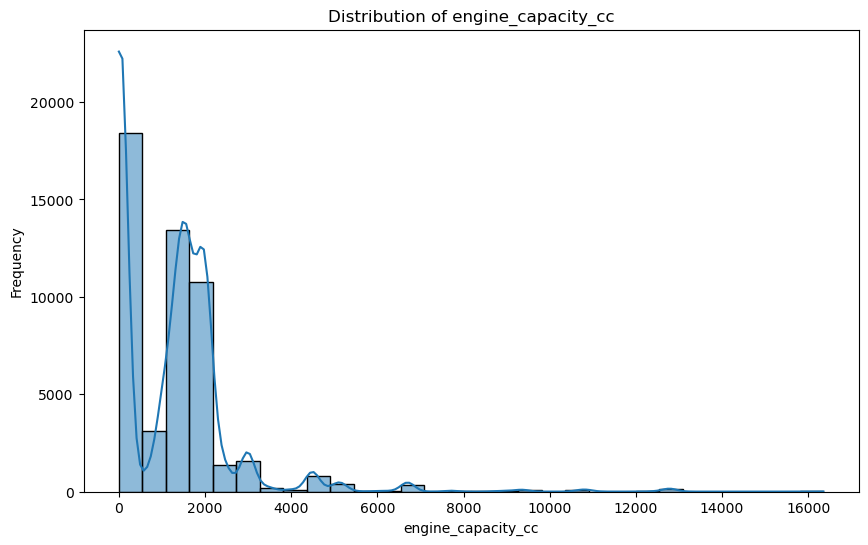

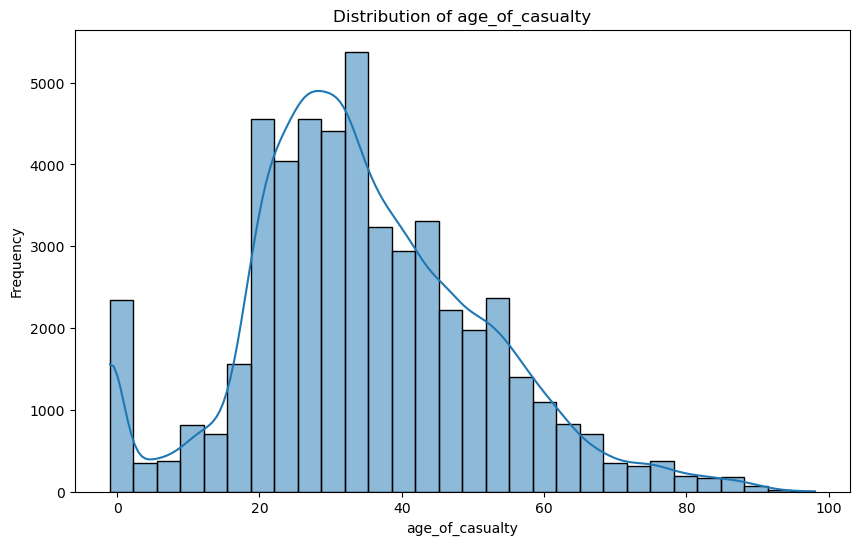

In [16]:
key_fields = ['engine_capacity_cc', 'age_of_casualty']

for field in key_fields:
    plt.figure(figsize=(10, 6))
    sns.histplot(final_merged_data[field], kde=True, bins=30)
    plt.title(f'Distribution of {field}')
    plt.xlabel(field)
    plt.ylabel('Frequency')
    plt.show()

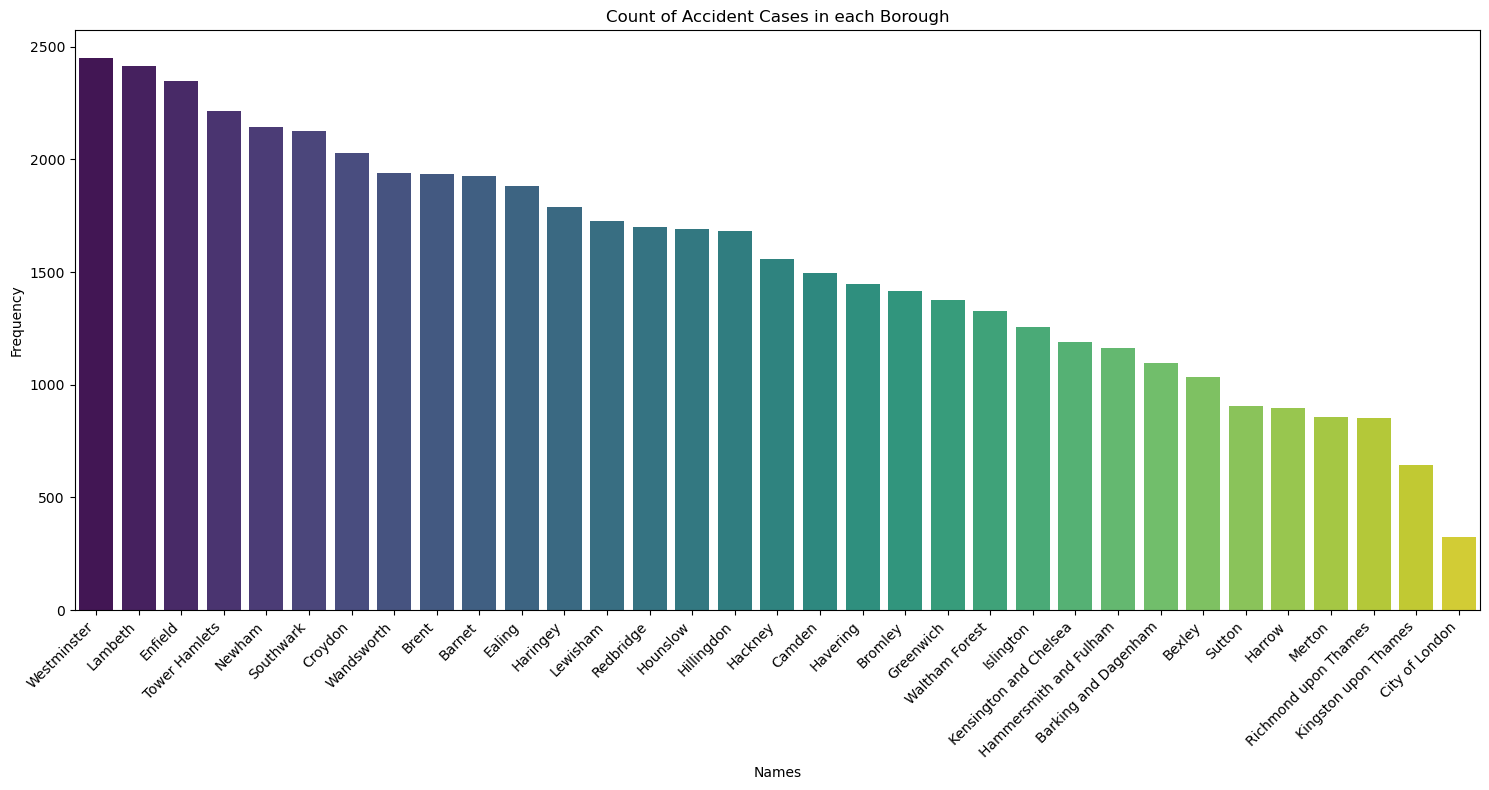

In [17]:
# plot the count of accident cases in each borough
name_counts = final_merged_data['NAME'].value_counts().reset_index()
name_counts.columns = ['NAME', 'count']
plt.figure(figsize=(15, 8))  
sns.barplot(data=name_counts, x='NAME', y='count', palette='viridis')
plt.title('Count of Accident Cases in each Borough')
plt.xlabel('Names')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

**Frequency of Target Variable Accident_severity**

We use the bar chart to depict the frequency of different levels of accident severity. As there are only three values 1,2,3 and each correspond to fatal,serious and slight accident correspondingly. The color red is used to denote fatal accidents while yellow represents serious accidents and green represents slight accidents. No wonder that the fatal accidents are rare which are less than 1000 while the slight accidents are most common reaching above 40000 cases yearly.

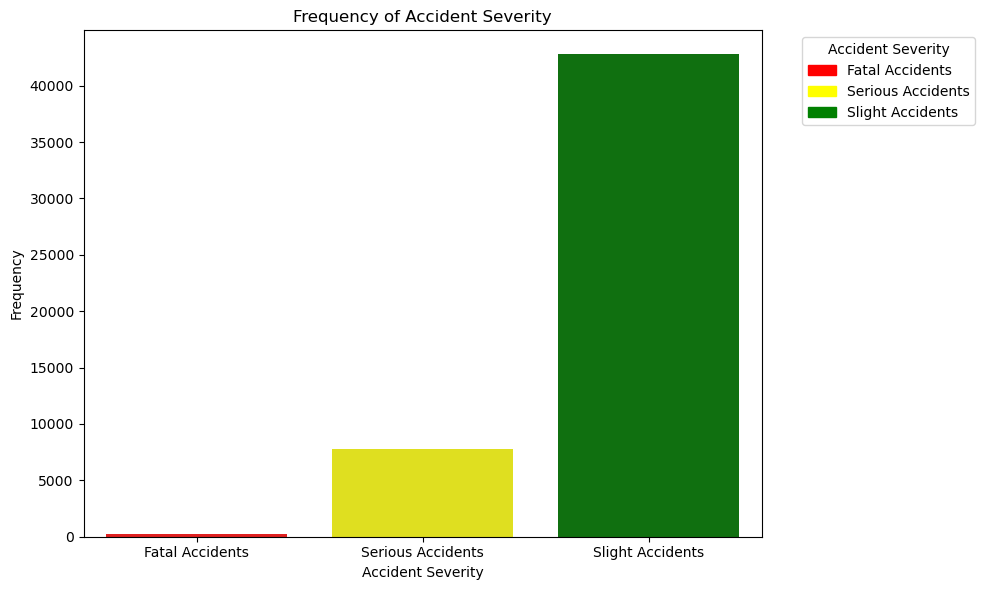

In [18]:
severity_counts = final_merged_data['accident_severity'].value_counts().sort_index().reset_index()
severity_counts.columns = ['accident_severity', 'count']

# Define the color map for each accident severity level
severity_color_map = {1: 'red', 2: 'yellow', 3: 'green'}

plt.figure(figsize=(10, 6))
sns.barplot(
    x='accident_severity', 
    y='count', 
    data=severity_counts, 
    palette=severity_color_map
)

plt.title('Frequency of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Fatal Accidents', 'Serious Accidents', 'Slight Accidents'])

colors = [severity_color_map[i] for i in sorted(severity_color_map.keys())]
labels = ['Fatal Accidents', 'Serious Accidents', 'Slight Accidents']
patches = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]
plt.legend(patches, labels, title='Accident Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3.2 Data Cleaning

We handle missing values and detect outliers. The strategy adopted for outlier management involved computing z-scores for numerical columns. Despite initially removing these outliers, a decision was made to retain them to avoid losing valuable information, particularly from boroughs with naturally higher variance like the City of London.

**Drop Missing Value**

In [19]:
# drop the rows have the missing value
final_merged_data=final_merged_data.dropna()

In [20]:
# check is there any missing value still exist in the dataframe
print("\nMissing Values Analysis:")
missing_values = final_merged_data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values Analysis:
Series([], dtype: int64)


**Detect Outliers**\
Besides the missing value, we also need to deal with the outliers. We took the z-score detection methods for finding the outliers.A z-score is defined as a measure of the divergence of an different experimental observations from the most probable result, the mean (Ioffe & Szegedy, 2015). Z is expressed in terms of the number of standard deviations from the mean value. 

X = Experimental Value \
μ = Mean \
σ = Standard Deviation

In [21]:
# select the numeric columns from the dataframe
numeric_cols = final_merged_data.select_dtypes(include=[np.number]).columns.tolist()
# calculate the z-score for each column
z_scores = np.abs(stats.zscore(final_merged_data[numeric_cols]))
# An outlier here is defined as a data point that has a Z-score greater than 3
outliers = (z_scores > 3).any(axis=1)

Here we calculated the z-score for each numeric column in dataframe final_merged_data. While the z-score represents the number of standard deviations away from the mean each value is and the outliers were the value corresponds to whether any value in that row has a z-score greater than 3.

In [22]:
# remove those defined outliers
df = final_merged_data[~outliers]

In [23]:
# check the shape for the new dataframe
df.shape

(25339, 87)

From the **map below** we can visualize the London boroughs plot with the cleaned dataset and it's pronounced that **three boroughs** have beenremoved especially one of them is **city of London** which is indispensible for the analysis. Additionally, as the values in the numerical columns don't conform to the normal distribution completely and in London the likelihood is that it will has extreme value especially in the borough like city of London which were removed by the outlier detection here. Therfore, we decided to **keep those outliers** to do the analysis for whole London. 

**Visualize the Outliers Removed**

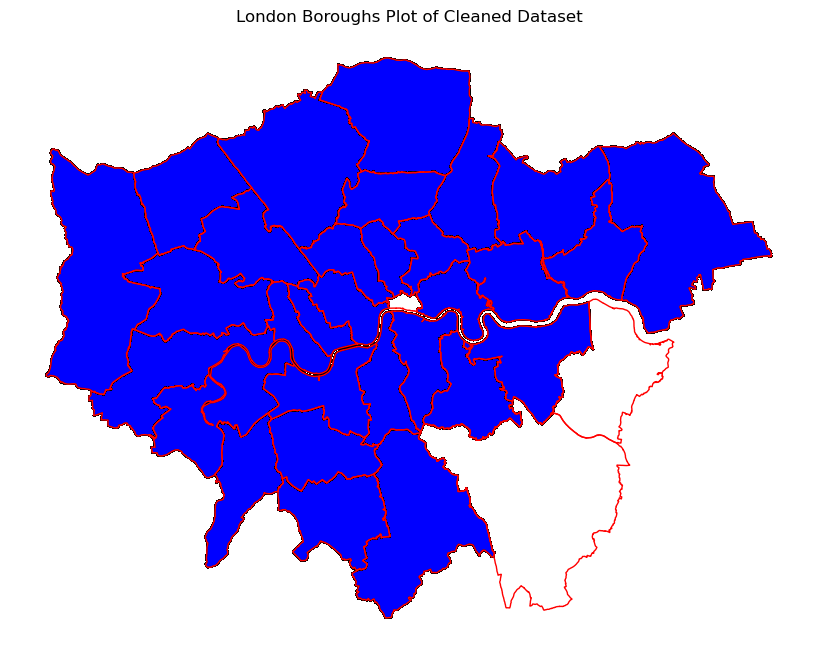

In [24]:
#plot the cleaned dataframe df overlayying on the ward dataframe to visualzie the removal boroughs
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Plot the cleaned boroughs
df.plot(ax=ax, color='blue', edgecolor='k', alpha=0.5)
# Overlay the wards on top
ward.plot(ax=ax, color='none', edgecolor='red')
ax.set_title('London Boroughs Plot of Cleaned Dataset')
ax.axis('off')
plt.show()

**Keep the Outliers**

In [25]:
df = final_merged_data# keep the outliers 

### 3.3 Feature Engineering

Feature engineering was pivotal in enriching the dataset with meaningful attributes that could potentially influence accident severity predictions.As it involves the application of transformation functions such as arithmetic and aggregate operators on given features to generate new ones (Nargesian et al., 2017). Also, new variables were created to distinguish between urban and rural settings, and to categorize times of accidents into weekdays and weekends. 

**Weekday VS Weekend**

As the day_of_week column in the original dataframe has 1-7 value represents Monday to Sunday correspondingly. Therefore, we set the rows whose value fall within 1-5 to be weekday and the others to be weekend.

In [26]:
# Create a new variable which represents the daytime and weekend while 1 means weekend 
df['Is_Weekend'] = df['day_of_week'].apply(lambda x: 1 if x > 5 else 0)

**Urban VS Rural**

From the UK census report of rural and urban classification report in 2011 we find that there are only two boroughs have rural features in that the classification defines areas as ruralreveals that while no single rural/urban classification can be utilized for all geographies, using such a product helps to better understand the differing characteristics of rural and urban areas in a consistent, transparent way. As there is no one-size-fits-all method. In turn, we're going to use the inner and outer London definition for the urban and rural instead which spells that the inner London represents the urban and outer for rural. Actually, we used the inner and outer London from UK census which defines the city of London and 13 boroughs as inner London and others as outer.

In [27]:
borough_classification = {
    # Urban boroughs
    'E09000001': 'Urban',  # City of London
    'E09000007': 'Urban',  # Camden
    'E09000011': 'Urban',  # Greenwich
    'E09000012': 'Urban',  # Hackney
    'E09000013': 'Urban',  # Hammersmith and Fulham
    'E09000019': 'Urban',  # Islington
    'E09000020': 'Urban',  # Kensington and Chelsea
    'E09000022': 'Urban',  # Lambeth
    'E09000023': 'Urban',  # Lewisham
    'E09000028': 'Urban',  # Southwark
    'E09000030': 'Urban',  # Tower Hamlets
    'E09000032': 'Urban',  # Wandsworth
    'E09000033': 'Urban',  # Westminster
    
    # Rural boroughs
    'E09000002': 'Rural',  # Barking and Dagenham
    'E09000003': 'Rural',  # Barnet
    'E09000004': 'Rural',  # Bexley
    'E09000005': 'Rural',  # Brent
    'E09000006': 'Rural',  # Bromley
    'E09000008': 'Rural',  # Croydon
    'E09000009': 'Rural',  # Ealing
    'E09000010': 'Rural',  # Enfield
    'E09000014': 'Rural',  # Haringey
    'E09000015': 'Rural',  # Harrow
    'E09000016': 'Rural',  # Havering
    'E09000017': 'Rural',  # Hillingdon
    'E09000018': 'Rural',  # Hounslow
    'E09000021': 'Rural',  # Kingston upon Thames
    'E09000024': 'Rural',  # Merton
    'E09000025': 'Rural',  # Newham
    'E09000026': 'Rural',  # Redbridge
    'E09000027': 'Rural',  # Richmond upon Thames
    'E09000029': 'Rural',  # Sutton
    'E09000031': 'Rural',  # Waltham Forest
}

# Applying classification to create a new variable Area_Type which indicates the borough is urban or rural
df['Area_Type'] = df['GSS_CODE'].map(borough_classification)


**Drop Useless Columns**

In [28]:
#drop the columns which are redundant after the feature engineering such as the index and the column like year as all data are in year 2022
columns_to_drop = [
    column for column in df.columns 
    if any(substring in column for substring in ['year','reference','lsoa','index','local_authority']) 
    or column in ['Hour_of_Day','time','day_of_week']
]
# Dropping the columns
df.drop(columns=columns_to_drop, inplace=True)

In [29]:
df_without_transformation=df# store the dataframe df here

### 3.4 Data Visualization

**Urban VS Rural**

We plot the urban and rural london boroughs according to ouer inner-and-outer London definition above. It's obvious that urban area refers to inner London in blue and rural refers to outer in green.

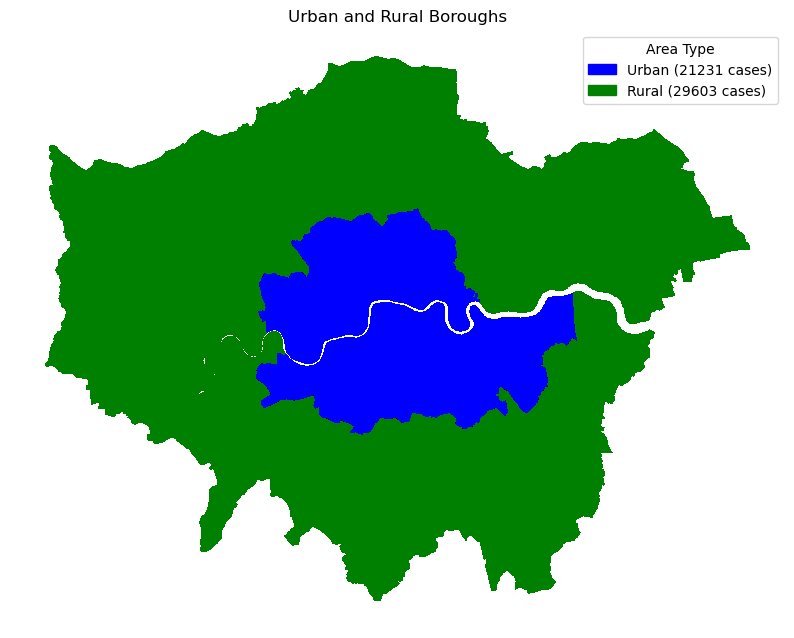

In [30]:
#use blue to represent urban area and green to represent rural area
color_map = {'Urban': 'blue', 'Rural': 'green'}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for ctype, data in df.groupby('Area_Type'):
    color = color_map.get(ctype, 'gray')  # Default to 'gray' if the type is not found in color_map
    data.plot(color=color, ax=ax, label=f'{ctype} ({len(data)} areas)')
legend_handles = [Patch(color=color, label=f"{ctype} ({len(df[df['Area_Type'] == ctype])} cases)") for ctype, color in color_map.items()]


plt.legend(handles=legend_handles, title='Area Type')
ax.set_axis_off()
plt.title('Urban and Rural Boroughs')
plt.show()

**Map Distribution of Accident Count in Weekend**

The map below indicates the distribution of accident cases across London boroughs during the weekend. We set the five levels for the frequency of accident cases:\
0-200: Very Low \
200-400: Low \
400-800: Medium \
800-1200: High \
1200-2500: Very High

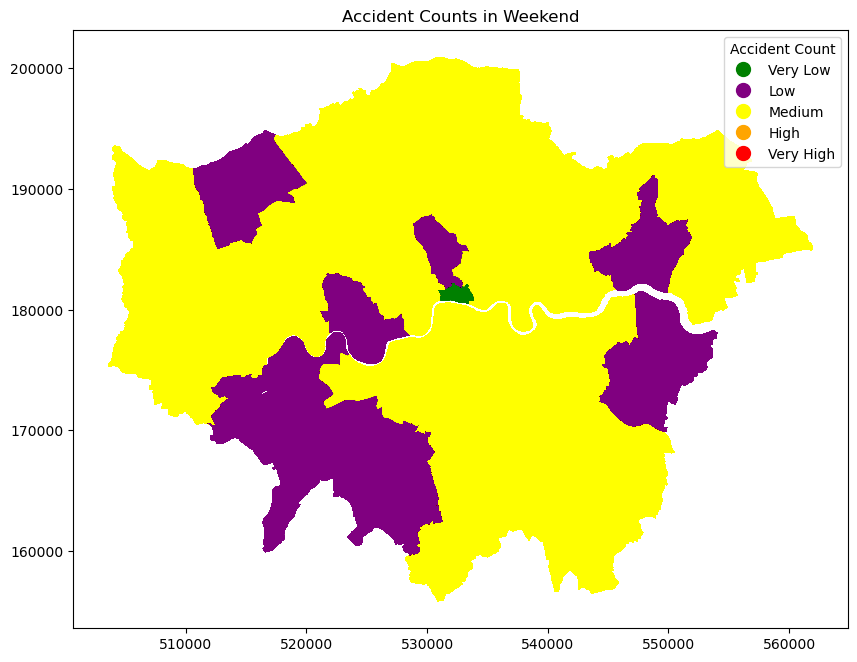

In [31]:
#filter the weekend data first
df_weekend=df[df['Is_Weekend']==1]
# Calculate the counts per borough
counts_per_borough = df_weekend['NAME'].value_counts().rename_axis('NAME').reset_index(name='counts')

# Merge the counts back to the original dataframe
df_weekend= df_weekend.merge(counts_per_borough, on='NAME')

# Define five levels based on counts (0-200:very low, 200-400:low,400-800:medium,800-1200:high,1200-2500:very high)
bins = [0, 200, 400, 800, 1200,2500]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_weekend['level'] = pd.cut(df_weekend['counts'], bins=bins, labels=labels,include_lowest=True)


# Define colors according to the level defined above
color_map = {'Very Low': 'green', 'Low': 'purple', 'Medium': 'yellow', 'High':'orange', 'Very High': 'red'}
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_weekend.plot(ax=ax, color=[color_map[level] for level in df_weekend['level']], legend=True)
plt.legend([plt.Line2D([0], [0], color=color, marker='o', linestyle='',markersize=10) for color in color_map.values()], color_map.keys(),title='Accident Count')
plt.title('Accident Counts in Weekend')
plt.show()

**Countplot for Boroughs which have very low and low frequency accident cases in weekend**

In [32]:
#define the function to make the countplot to follow the same color scheme with the map distribution
def get_color(count):
    if count <200:
        return 'green'  # Very Low
    else:
        return 'purple'  # Low

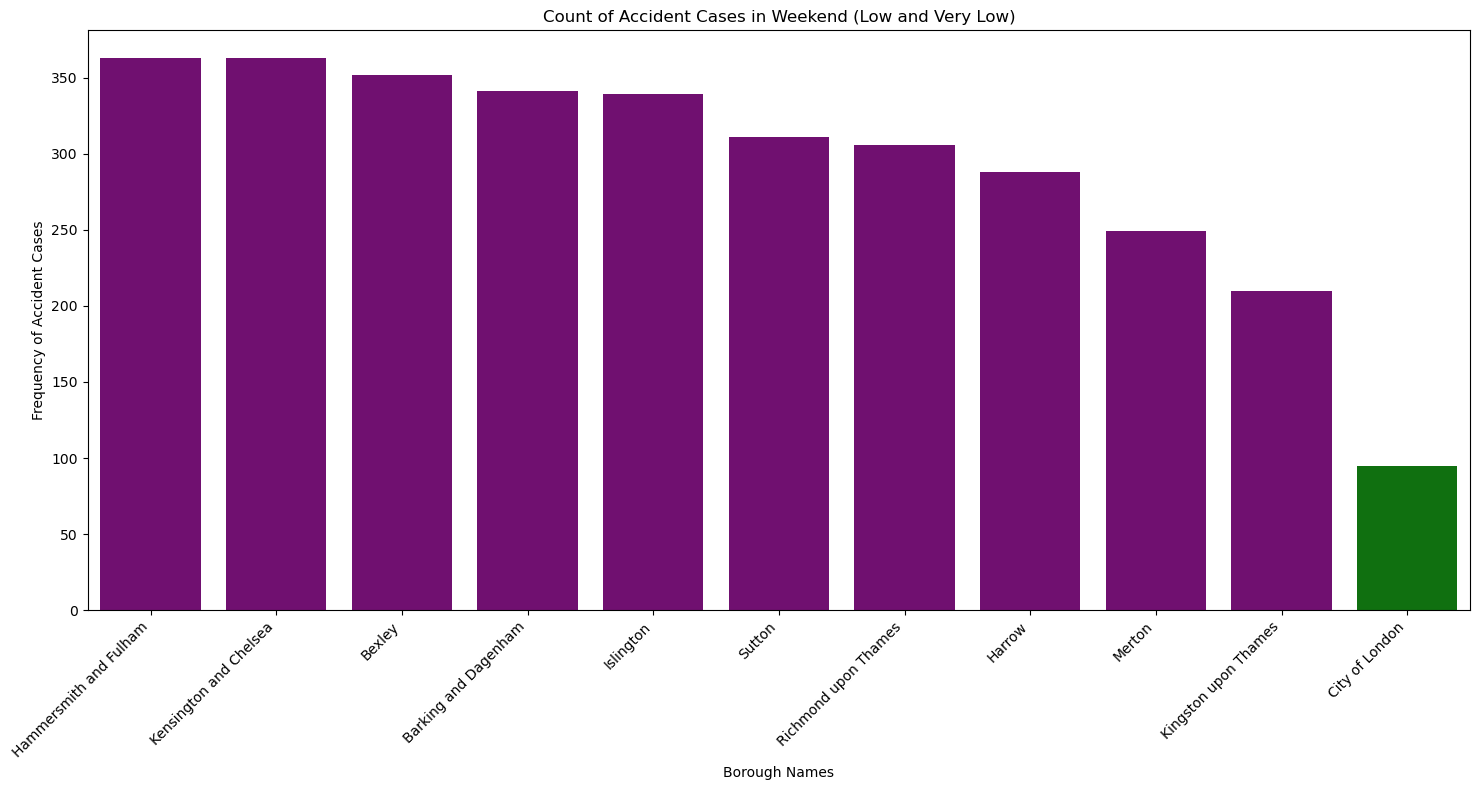

In [33]:
name_counts = df_weekend['NAME'].value_counts().reset_index()
name_counts.columns = ['NAME', 'count']

# Filter to include only boroughs with less than 400 cases
filtered_name_counts = name_counts[name_counts['count'] <400]
# Create a list of colors for each borough based on the 'count' value
colors = filtered_name_counts['count'].apply(get_color)
# Plot the counts of accident cases for filtered boroughs
plt.figure(figsize=(15, 8))
sns.barplot(data=filtered_name_counts, x='NAME', y='count',  palette=colors)
plt.title('Count of Accident Cases in Weekend (Low and Very Low)')
plt.xlabel('Borough Names')
plt.ylabel('Frequency of Accident Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The countplot and the map above suggests that city of London has less than 200 accidents on the weekend in year 2022 and most boroughs have 400-800 accident cases on the weekend. It seems that the occurrences of accidents are not common during the weekend in whole London.

**Map Distribution of Accident Count in Weekend**

The map below indicates the distribution of accident cases across London boroughs during the weekdays. We set the five levels for the frequency of accident cases:\
0-400: Very Low \
400-800: Low \
800-1200: Medium \
1200-1600: High \
1600-2500: Very High

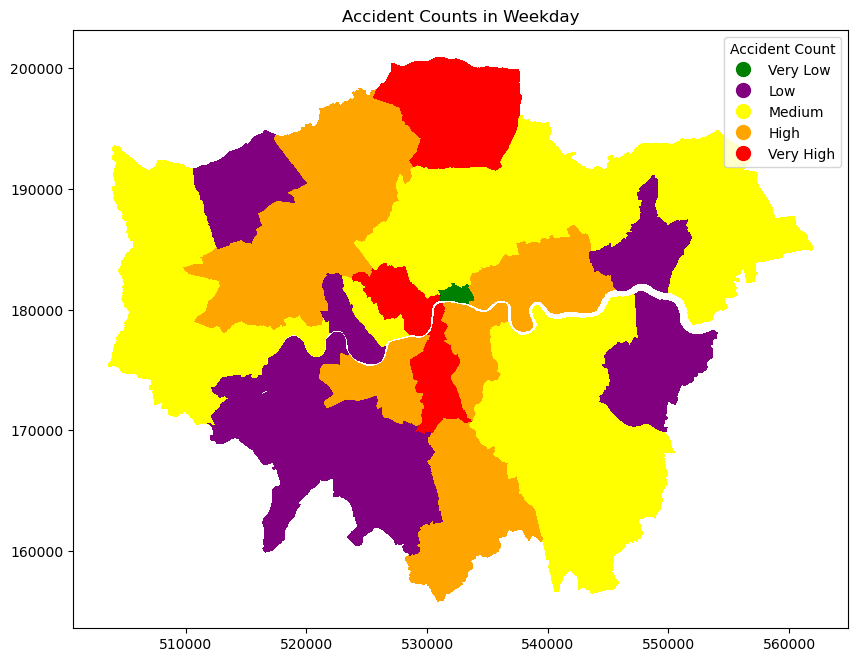

In [34]:
#filter the weekeday data first
df_weekday=df[df['Is_Weekend']==0]
# Calculate the counts per borough
counts_per_borough = df_weekday['NAME'].value_counts().rename_axis('NAME').reset_index(name='counts')

# Merge the counts back to the original dataframe
df_weekday= df_weekday.merge(counts_per_borough, on='NAME')

# Define five levels based on counts (0-400:very low, 400-800:low,800-1200:medium,1200-1600:high,1600-2500:very high)
bins = [0, 400, 800, 1200, 1600,2500]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_weekday['level'] = pd.cut(df_weekday['counts'], bins=bins, labels=labels,include_lowest=True)


# Define colors according to the level defined above
color_map = {'Very Low': 'green', 'Low': 'purple', 'Medium': 'yellow', 'High':'orange', 'Very High': 'red'}
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_weekday.plot(ax=ax, color=[color_map[level] for level in df_weekday['level']], legend=True)
plt.legend([plt.Line2D([0], [0], color=color, marker='o', linestyle='',markersize=10) for color in color_map.values()], color_map.keys(),title='Accident Count')
plt.title('Accident Counts in Weekday')
plt.show()

**Countplot for Boroughs which have very low and low frequency accident cases in weekday**

In [35]:
#define the function to make the countplot to follow the same color scheme with the map distribution
def get_color_weekend(count):
    if count> 1600:
        return 'red'  # Very High
    else:
        return 'orange'  # high

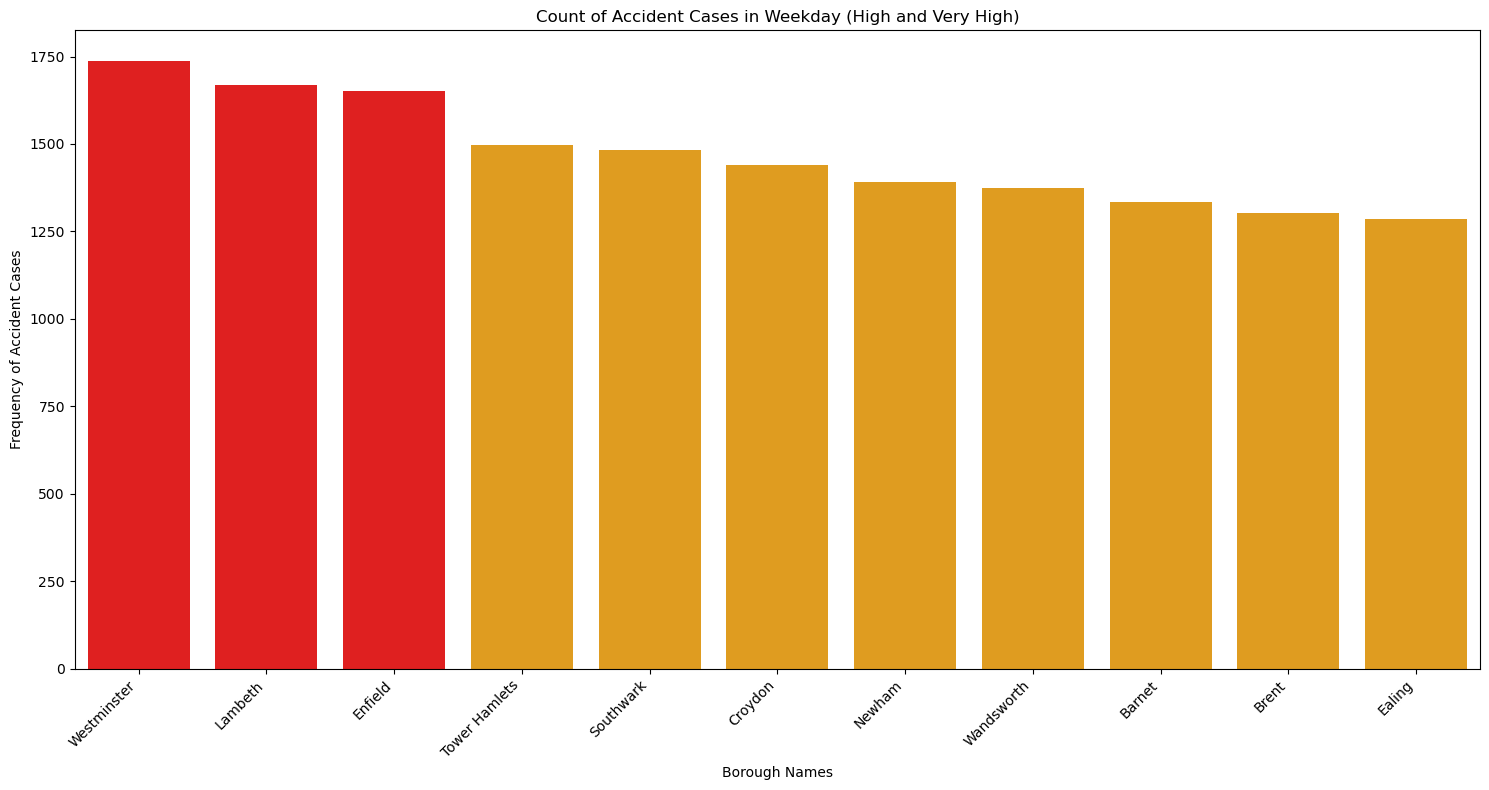

In [36]:
name_counts = df_weekday['NAME'].value_counts().reset_index()
name_counts.columns = ['NAME', 'count']

# Filter to include only boroughs with more than 1200 cases
filtered_name_counts = name_counts[name_counts['count']>1200]
# Create a list of colors for each borough based on the 'count' value
colors = filtered_name_counts['count'].apply(get_color_weekend)
# Plot the counts of accident cases for filtered boroughs
plt.figure(figsize=(15, 8))
sns.barplot(data=filtered_name_counts, x='NAME', y='count',  palette=colors)
plt.title('Count of Accident Cases in Weekday (High and Very High)')
plt.xlabel('Borough Names')
plt.ylabel('Frequency of Accident Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the two plots below we can find that during weekday, the boroughs in urban(inner) London have the most accident cases such as Westminster, Lambeth which both have more than 1500 accidents cases in year 2022 while some rural(outer) areas have most accident cases as well which may suggest a possible traffic pattern. As on weekday, it's common for people to drive from outer London to Inner London or take public transportations. Correspondingly, it underscores the importance of considering temporal and spatial dynamics in predictive modeling

**Map Distribution According to Accident Severity in Weekend**

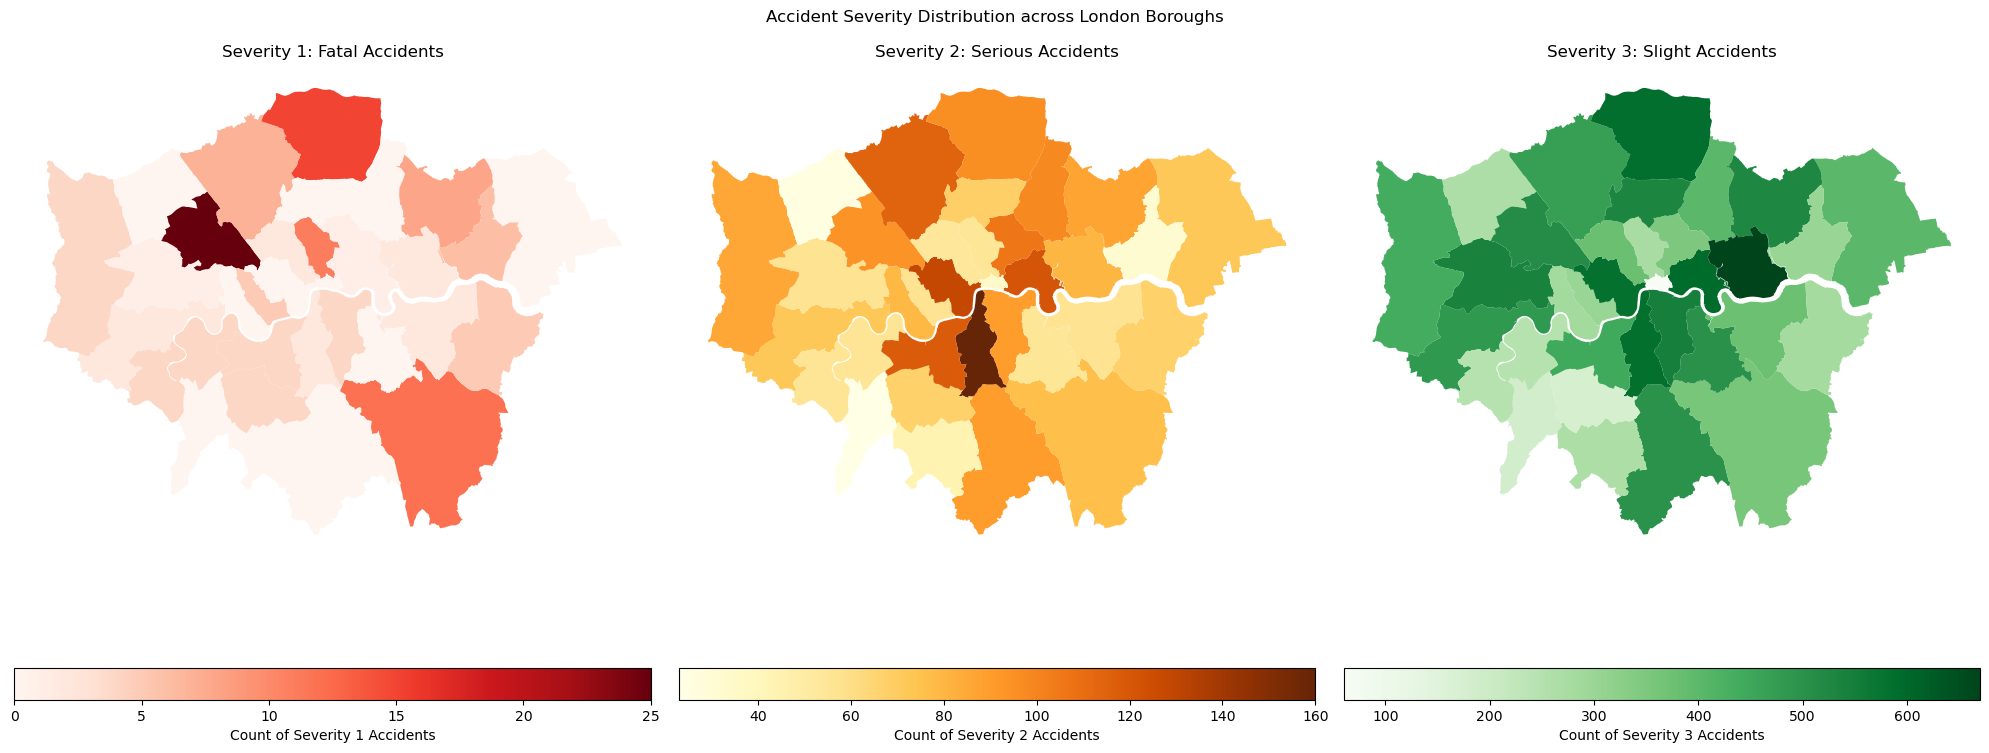

In [37]:
# Count the number of accidents by severity and borough in weekend
accidents_by_severity = df_weekend.groupby(['NAME', 'accident_severity']).size().unstack(fill_value=0)
# Join this back with the borough geometries 
borough_geometry = df_weekend[['NAME', 'geometry']].drop_duplicates('NAME')
borough_severity = borough_geometry.merge(accidents_by_severity, on='NAME', how='left')

#define the color map for the severity of the accident while red for severity 1, yellow for severity 2 and green for severity 3
cmaps = ['Reds', 'YlOrBr', 'Greens']
severity_titles = {
    1: 'Severity 1: Fatal Accidents',
    2: 'Severity 2: Serious Accidents',
    3: 'Severity 3: Slight Accidents'
}
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
for idx, (ax, severity_level) in enumerate(zip(axs, [1, 2, 3])):
    borough_severity.plot(ax=ax, column=severity_level, cmap=cmaps[idx], legend=True,
    legend_kwds={'label': f"Count of Severity {severity_level} Accidents",'orientation': "horizontal"})
    ax.set_title(severity_titles[severity_level])
    ax.axis('off')
plt.suptitle('Accident Severity Distribution across London Boroughs')
plt.tight_layout()
plt.show()

**Countplot by Accident Severity Level in Weekend**

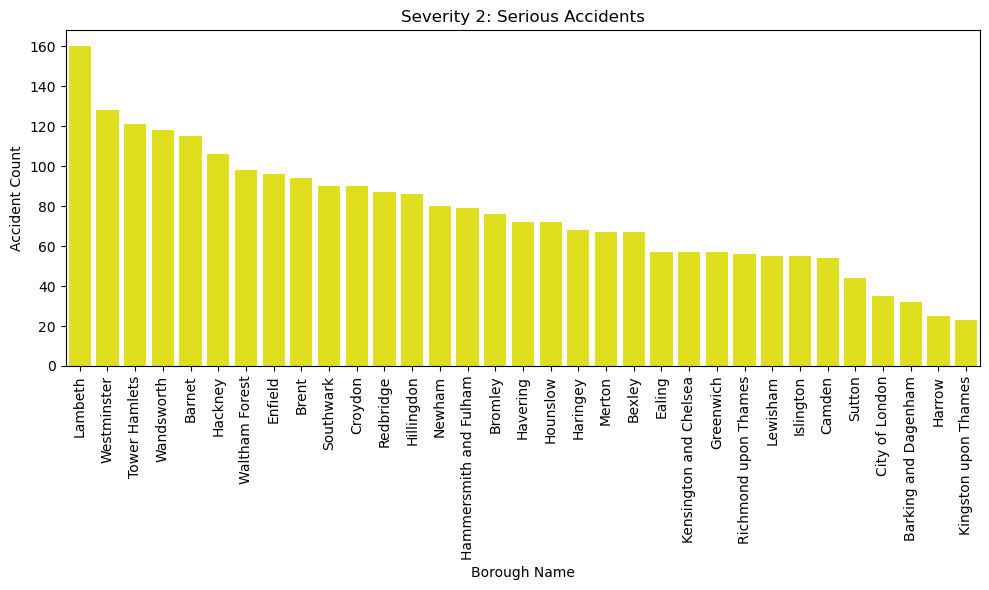

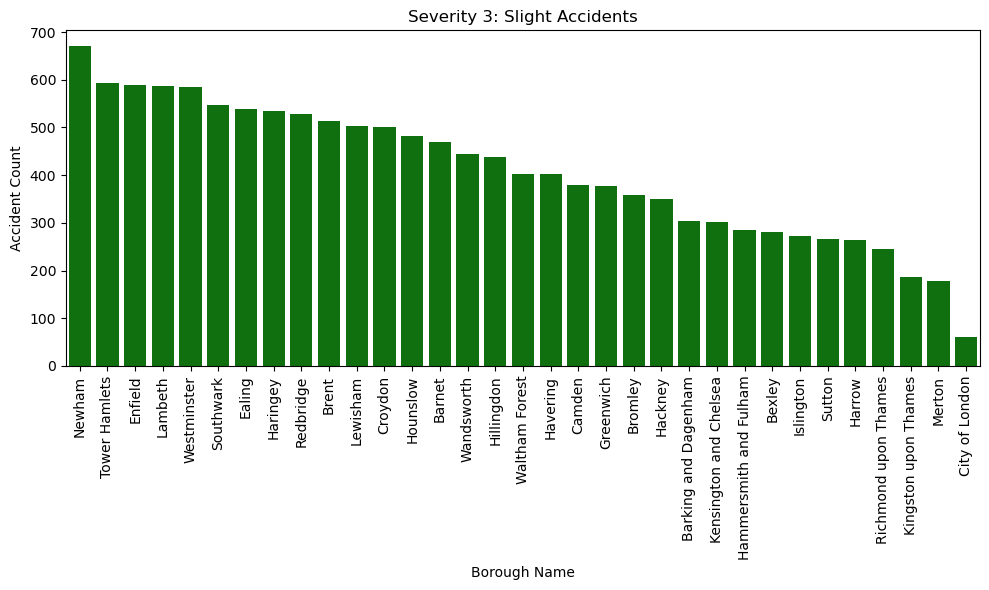

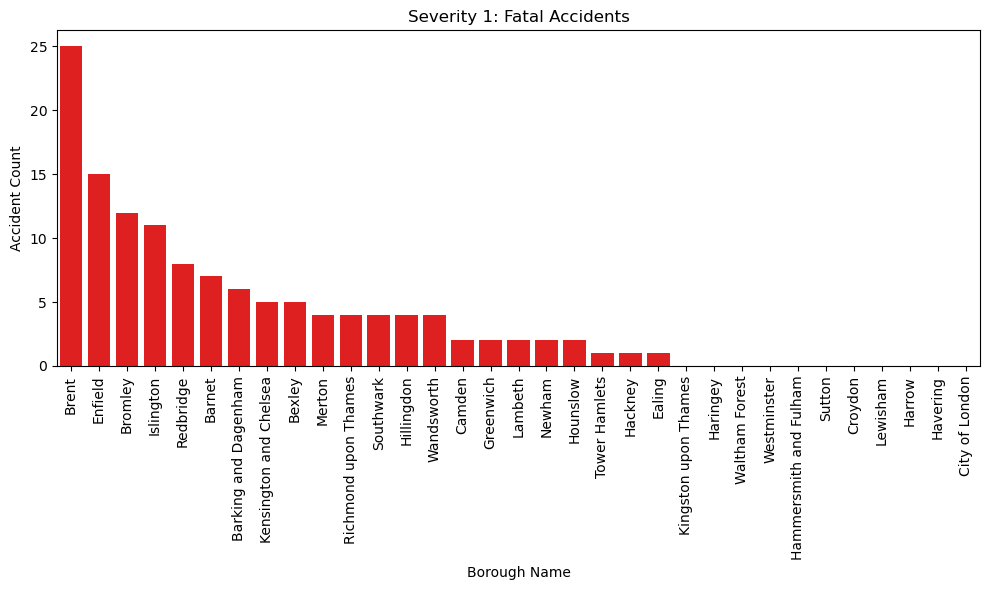

In [38]:
# Follow the same color scheme as the map distribution for accident severity level
severity_color_map = {1: 'red', 2: 'yellow', 3: 'green'}
severity_titles = {
    1: 'Severity 1: Fatal Accidents',
    2: 'Severity 2: Serious Accidents',
    3: 'Severity 3: Slight Accidents'
}
severity_levels = df_weekend['accident_severity'].unique()
# Plot each severity level in separate plots
for severity_level in severity_levels:
    plt.figure(figsize=(10, 6))
    subset = borough_severity[['NAME', severity_level]].sort_values(by=severity_level, ascending=False)
    
    # Plot the barplot
    sns.barplot(
        x='NAME', 
        y=severity_level, 
        data=subset,
        color=severity_color_map[severity_level]
    )
    plt.title(severity_titles[severity_level])
    plt.xlabel('Borough Name')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=90) 
    plt.tight_layout()
    plt.show()


From the visualization above, we find that the Brent has the most fatal accidents during the weekend and the Borough Enfield seems to have most accident cases for both three levels. Also, the borough Lambeth doesn't have much fata accidents but it has most serious and slight accidents. As a result, these two borough seems to need more attention to be paid regarding the road safety measures and deeper research can focus on these boroughs only.

**Map Distribution According to Accident Severity in Weekday**

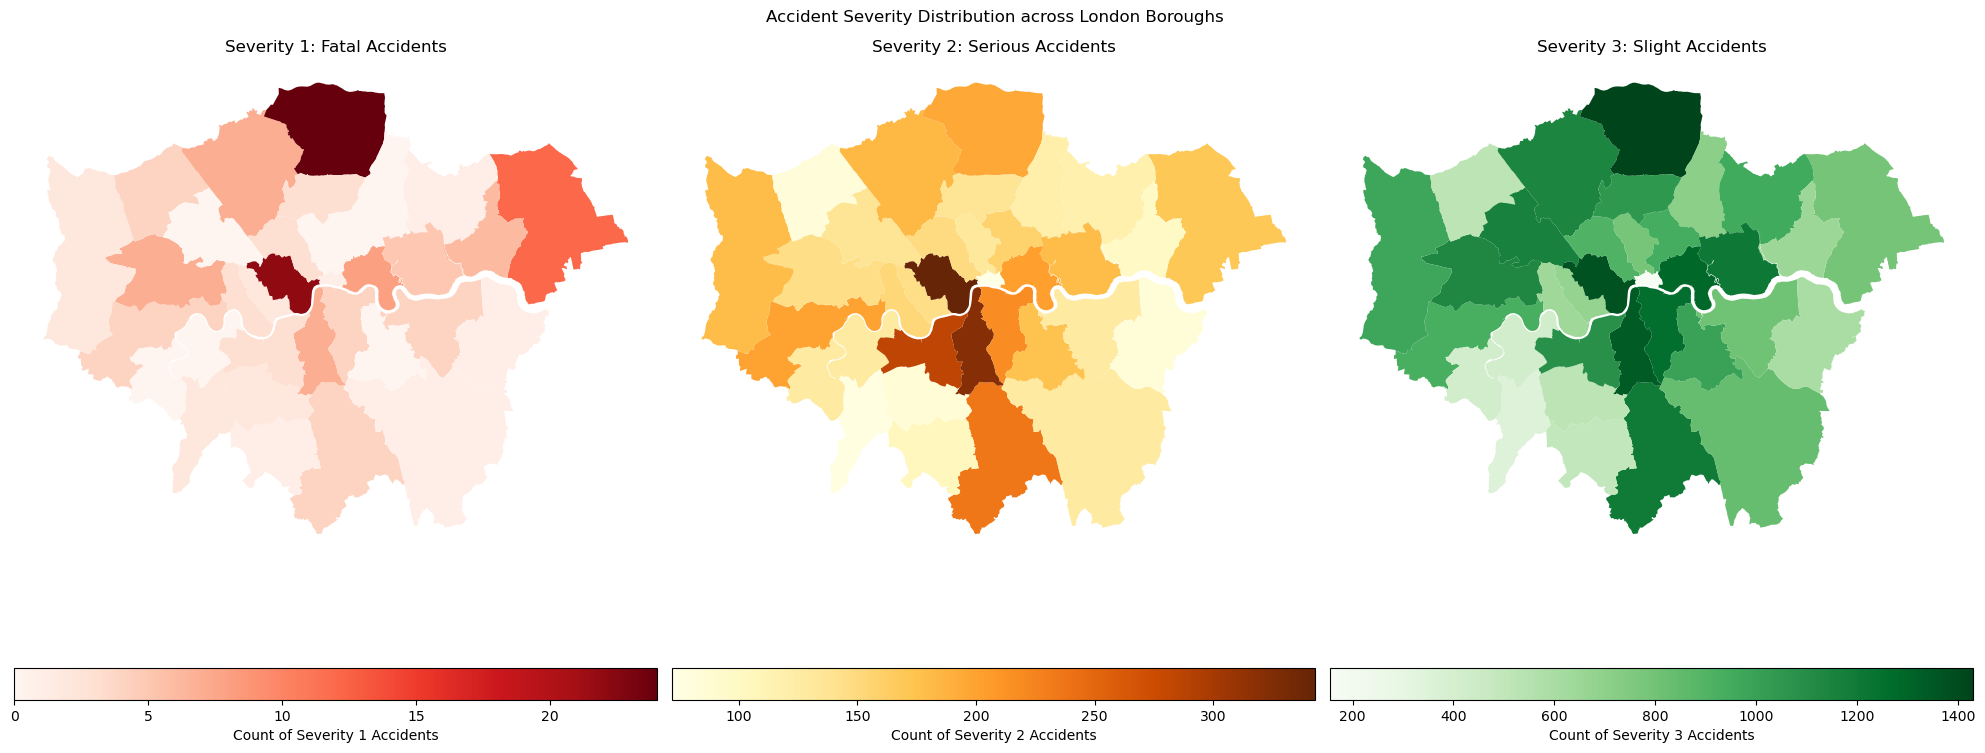

In [39]:
# Count the number of accidents by severity and borough in weekday
accidents_by_severity = df_weekday.groupby(['NAME', 'accident_severity']).size().unstack(fill_value=0)
# Join this back with the borough geometries 
borough_geometry = df_weekday[['NAME', 'geometry']].drop_duplicates('NAME')
borough_severity = borough_geometry.merge(accidents_by_severity, on='NAME', how='left')

#define the color map for the severity of the accident while red for severity 1, yellow for severity 2 and green for severity 3
cmaps = ['Reds', 'YlOrBr', 'Greens']
severity_titles = {
    1: 'Severity 1: Fatal Accidents',
    2: 'Severity 2: Serious Accidents',
    3: 'Severity 3: Slight Accidents'
}
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
for idx, (ax, severity_level) in enumerate(zip(axs, [1, 2, 3])):
    borough_severity.plot(ax=ax, column=severity_level, cmap=cmaps[idx], legend=True,
    legend_kwds={'label': f"Count of Severity {severity_level} Accidents",'orientation': "horizontal"})
    ax.set_title(severity_titles[severity_level])
    ax.axis('off')
plt.suptitle('Accident Severity Distribution across London Boroughs')
plt.tight_layout()
plt.show()

**Countplot by Accident Severity Level in Weekday**

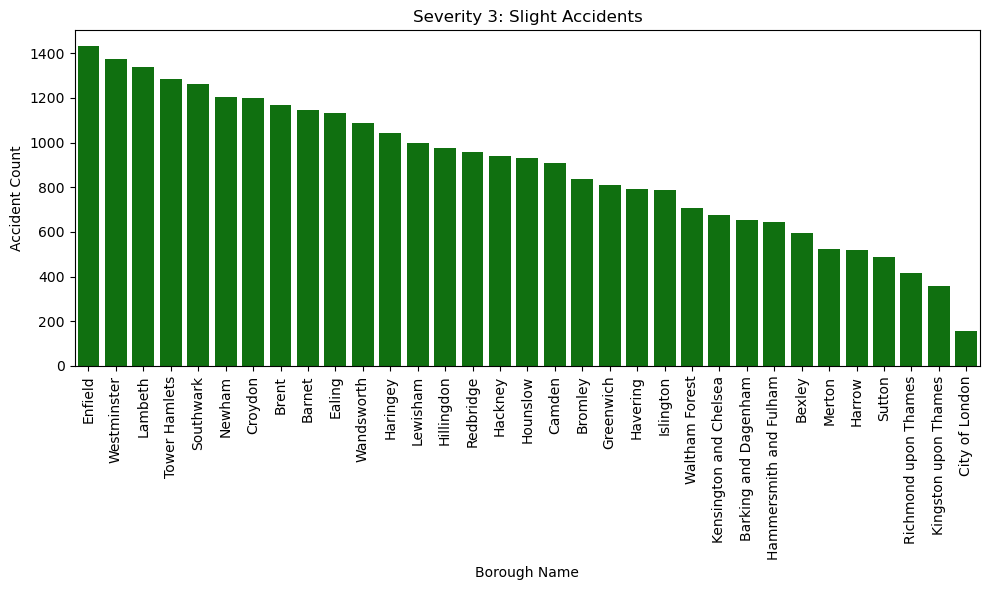

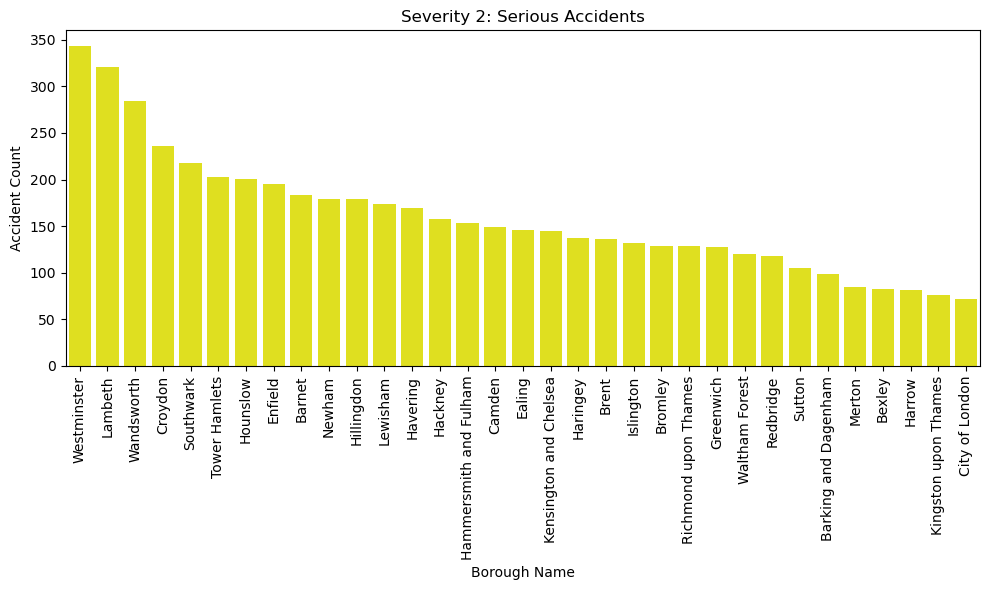

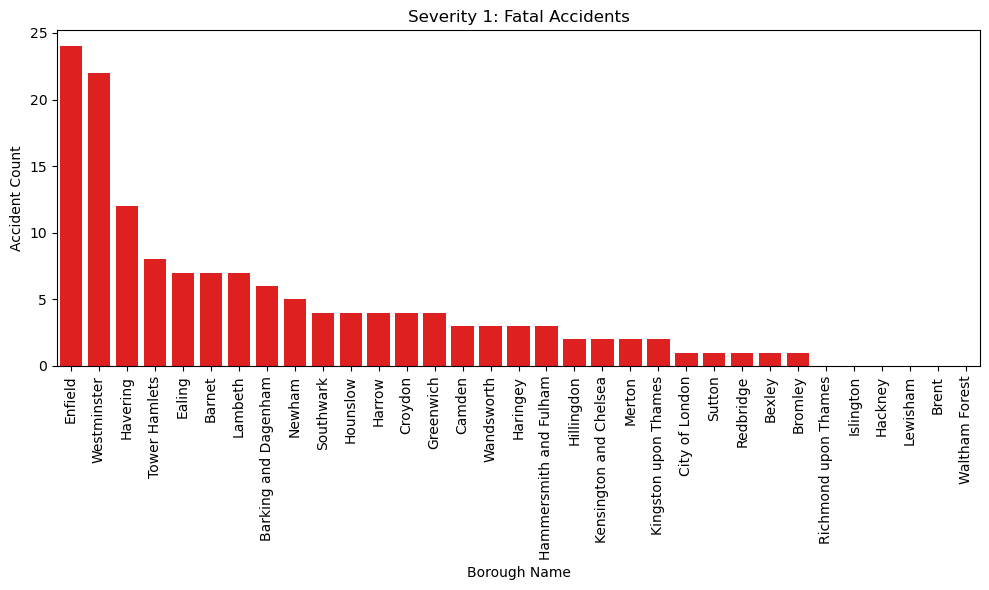

In [40]:
# Follow the same color scheme as the map distribution for accident severity level
severity_color_map = {1: 'red', 2: 'yellow', 3: 'green'}
severity_titles = {
    1: 'Severity 1: Fatal Accidents',
    2: 'Severity 2: Serious Accidents',
    3: 'Severity 3: Slight Accidents'
}
severity_levels = df_weekday['accident_severity'].unique()
# Plot each severity level in separate plots
for severity_level in severity_levels:
    plt.figure(figsize=(10, 6))
    subset = borough_severity[['NAME', severity_level]].sort_values(by=severity_level, ascending=False)
    
    # Plot the barplot
    sns.barplot(
        x='NAME', 
        y=severity_level, 
        data=subset,
        color=severity_color_map[severity_level]
    )
    plt.title(severity_titles[severity_level])
    plt.xlabel('Borough Name')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=90) 
    plt.tight_layout()
    plt.show()


Similar to what we have found during the weekend, the Lambeth and Enfield also have high number of accident cases for both three levels on weekday. Additionally, Westminster seems to fall victim to the accident cases most seriously as its number of accident cases all rank top3 for both three levels. In a word, the w

## 4.0 Methods

In this phase, the data transformation which involves encoding, multicolinearity check and the PCA method will be used for dimensionaity reduction since we have about 90 variables. Also, the tree-based methods including decision tree, random forest and ADT-boosted decision tree will be implemented to compare the predictability of each model. Finally, we will provide interpretable insights that could inform policy or operational decisions from the decision rules.

### 4.1 Data Transformation 

**Binary Encoding**

Conversion of categorical variables such as Area_Type to a binary format while 1 for urban and 0 for rural area.

In [41]:
# Transform the variable daytime and area_type to binary value 1 and 0 for the correlation and pca later
def binary_encoding(row):
    if row=='urban':
        return 1  # Urban in Area_Type column
    else:
        return 0  # Rural in Area_Type column
# Make the column area_type to be numeric
df['Area_Type'] = df['Area_Type'].apply(binary_encoding)

**Transforming the Numeric Features**

Application of standard scaling to numeric features and we remove the **accident_severity** as it's target variable.

In [42]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('accident_severity')  # Remove the target varaible accident_severity here

### 4.2 Multicolinearity Check

**Correlation Matrix**

Multicollinearity refers to the linear relationship among two or more variables, which also means lack of orthogonality among them (Alin, 2010) causing errors in data analysis results. Therefore, before the implementation of our model we need to check the relationships between variables to avoid **multicollinearity** first. 

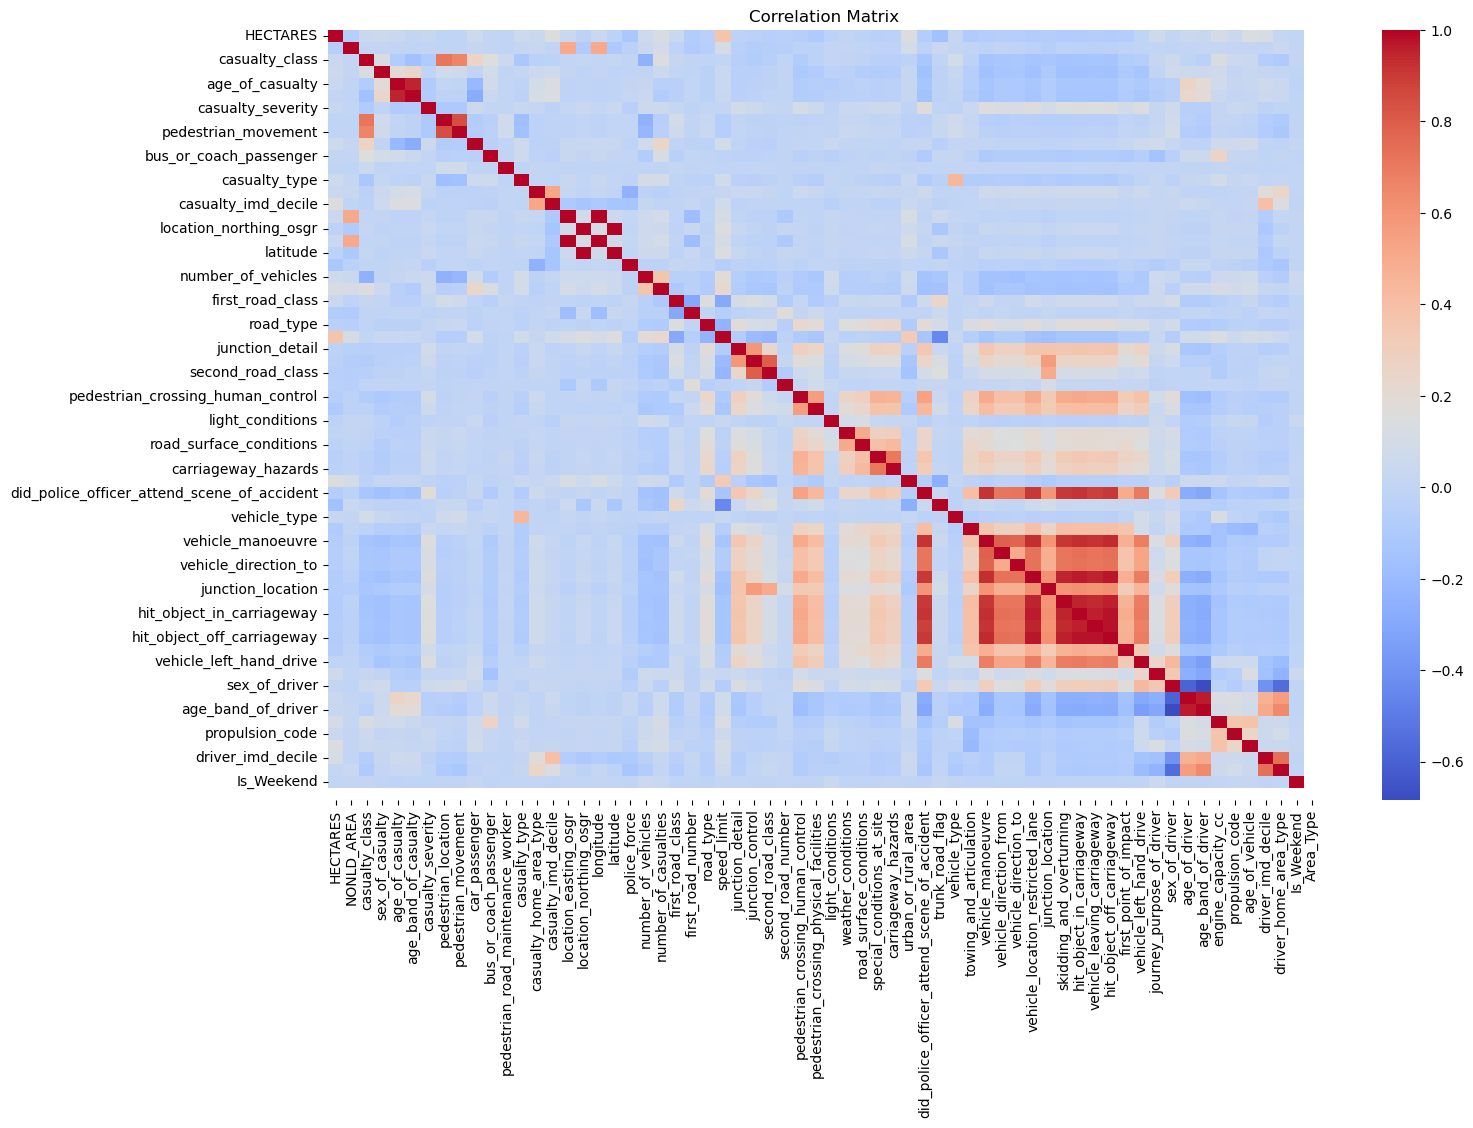

In [43]:
# Calculate the correlation matrix for numeric features
corr_matrix = df[numeric_features].corr()
# Plotting the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 4.3  Decision Tree without PCA Components

The decision trees provide straightforward interpretations of the decision-making process .As each split in the tree corresponds to a decision based on a particular feature, making it easy to understand and explain to stakeholders. However, the PCA test, on the other hand, transforms the original features into a new set of orthogonal features, which makes it **harder to interpret**. Therefore, if we want to reach concrete conclusion from the decision rules we need to do the tree-based method **without the PCA test** first. 

**Drop Highly Correlated Variables**

Since we're not doing the PCA test we need to drop those highly correlated variabels first. We set the threshold here to be **0.8** which means that if the correaltion coefficient between two variables is above 0.8 then those highly correlated variables will be **removed** in order to avoid mulitcollinearity as it will provide redundant information leading to possible overfitting for the tree-based methods.

In [44]:
corr_matrix = df_without_transformation[numeric_features].corr()

# Find features that are highly correlated and remove them
# Here, we create a mask for correlations greater than 0.8
highly_correlated = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            highly_correlated.add(colname)

# Drop highly correlated features
df_reduced = df_without_transformation.drop(columns=list(highly_correlated))

# Update your numeric_features to reflect the removed features
numeric_features = [feature for feature in numeric_features if feature not in highly_correlated]

**Plot the Correlation Matrix with highly-correlated variables removed**

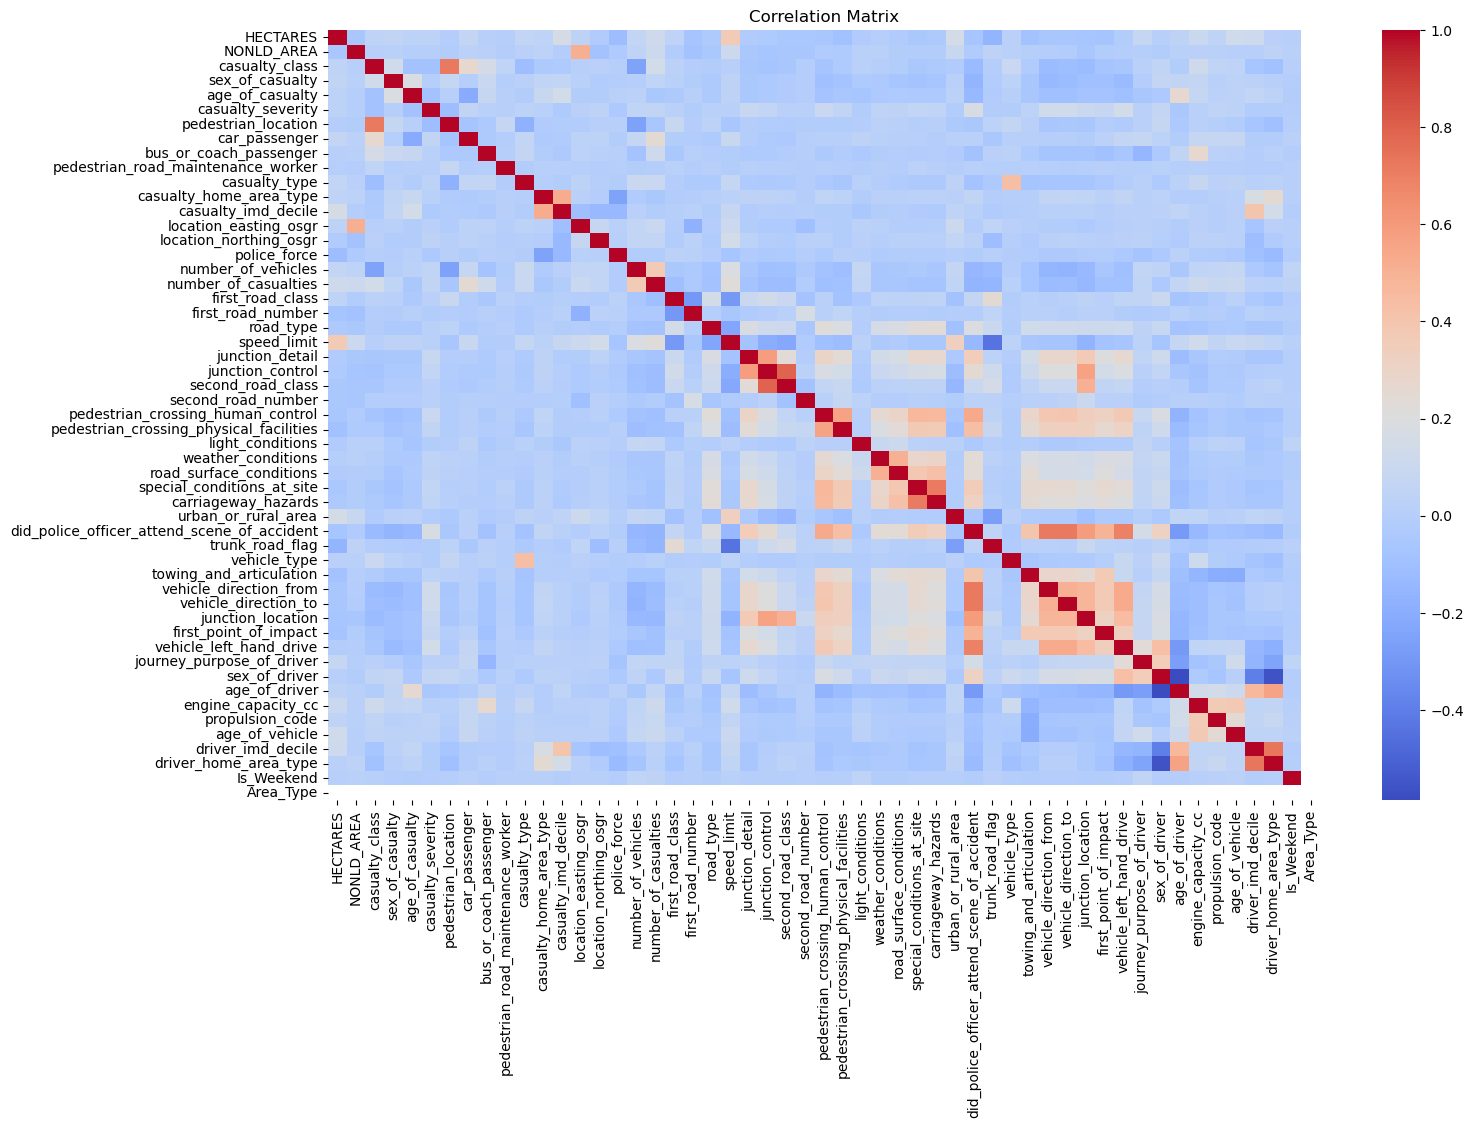

In [45]:
corr_matrix_dropped=df_without_transformation[numeric_features].corr()
# Plotting the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix_dropped, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We're visualizing and exporting the decision rules here. Also, we evaluate the classifier’s accuracy on the test data.

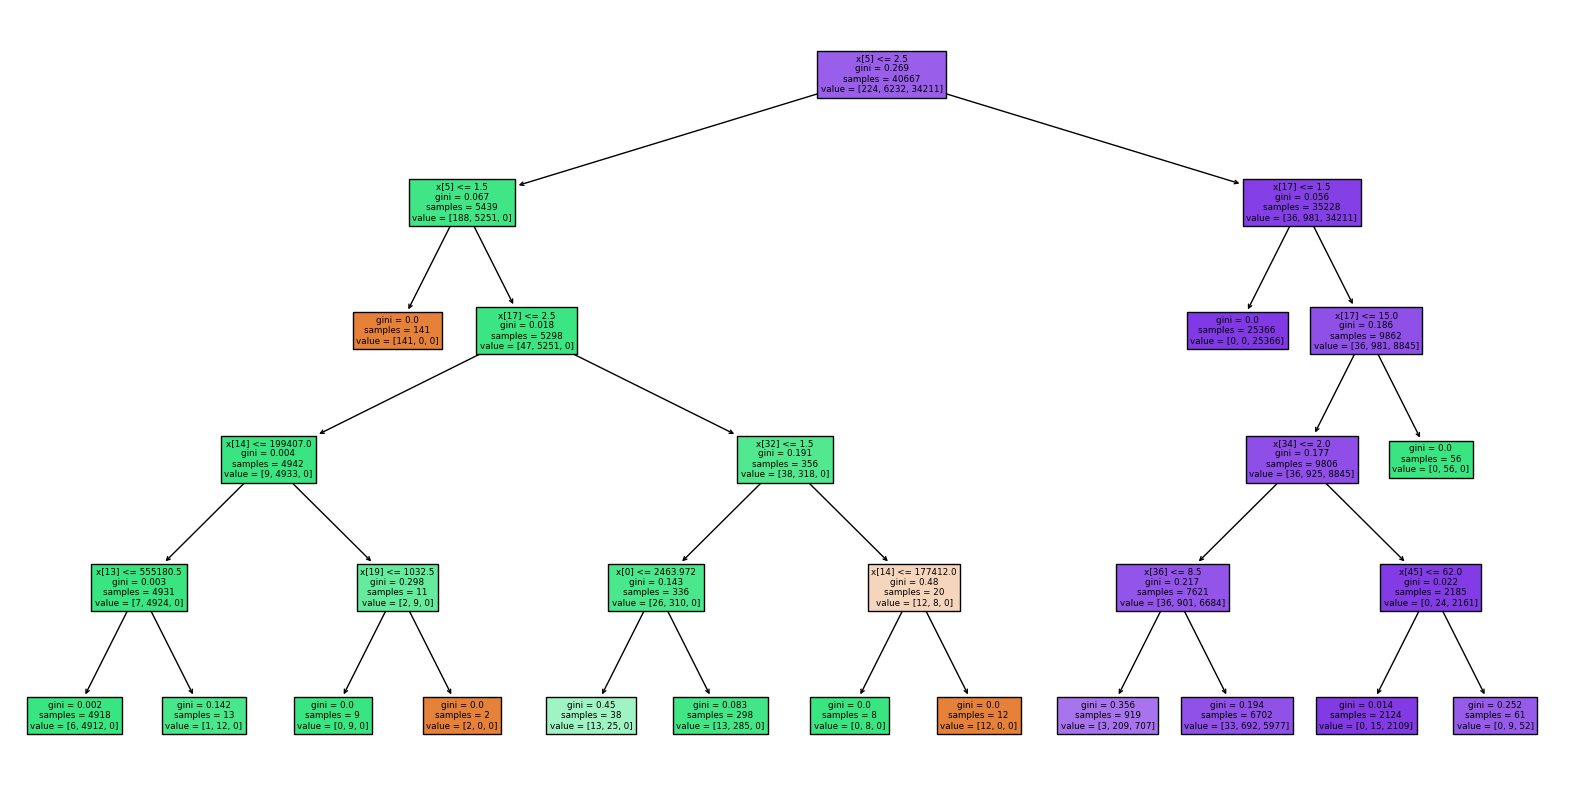

|--- casualty_severity <= 2.50
|   |--- casualty_severity <= 1.50
|   |   |--- class: 1
|   |--- casualty_severity >  1.50
|   |   |--- number_of_casualties <= 2.50
|   |   |   |--- location_northing_osgr <= 199407.00
|   |   |   |   |--- location_easting_osgr <= 555180.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- location_easting_osgr >  555180.50
|   |   |   |   |   |--- class: 2
|   |   |   |--- location_northing_osgr >  199407.00
|   |   |   |   |--- first_road_number <= 1032.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- first_road_number >  1032.50
|   |   |   |   |   |--- class: 1
|   |   |--- number_of_casualties >  2.50
|   |   |   |--- carriageway_hazards <= 1.50
|   |   |   |   |--- HECTARES <= 2463.97
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- HECTARES >  2463.97
|   |   |   |   |   |--- class: 2
|   |   |   |--- carriageway_hazards >  1.50
|   |   |   |   |--- location_northing_osgr <= 177412.00
|   |   |   |   |   |--- class: 2
|   |   

In [46]:
X_reduced = df_reduced[numeric_features]
y = df_reduced['accident_severity']
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

clf =DecisionTreeClassifier(random_state=42,max_depth=5)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True)
plt.show()

# To export the decision rules, we use the export_text function
text_representation = export_text(clf, feature_names=numeric_features)
print(text_representation)
# Check the performance on the test set
accuracy = clf.score(X_test, y_test)
print(f"Accuracy on the test set: {accuracy:.2f}")

### 4.4 Dimensionality Reduction

We implement Principal Component Analysis (PCA) to reduce the dimensionality enhancing model efficiency and potentially improving performance by removing noise as we have more than 70 features in our dataset. Actually, we're using the PCA to select the optimal number of components using the **elbow method** to find the knee point to find the best number of component.

Text(0, 0.5, 'Cumulative Explained Variance')

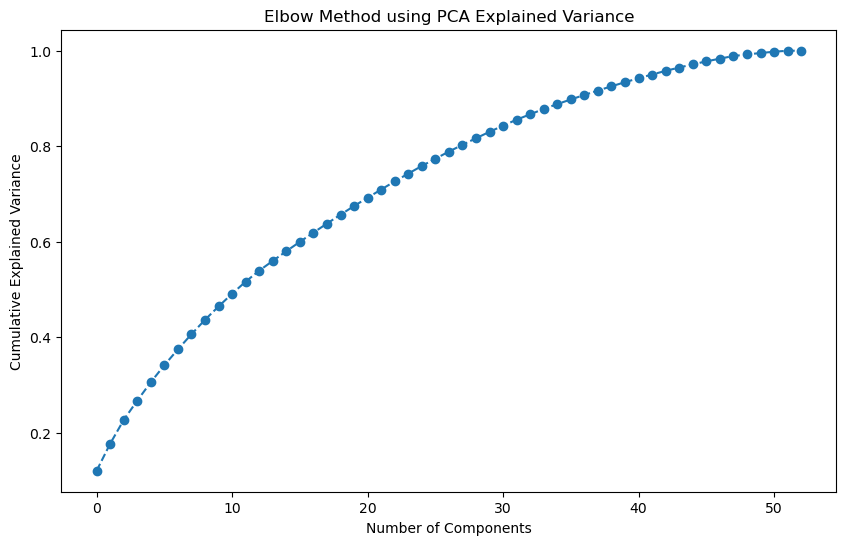

In [47]:
# Scaling numeric features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

pca = PCA().fit(df[numeric_features])
# Calculate the explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot for the elbow method
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.title('Elbow Method using PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

**Select the Optimal Number of Components**

The number of components is important because if the number of components kept is too small, relevant information is not taken into account in the analysis (Josse & Husson, 2012). As seen in the graph, the curve starts to plateau after about 27 components, which indicates that additional components beyond this point contribute less to the variance of the dataset. Therefore, we have selected the **optimal number of components** to be **27**.

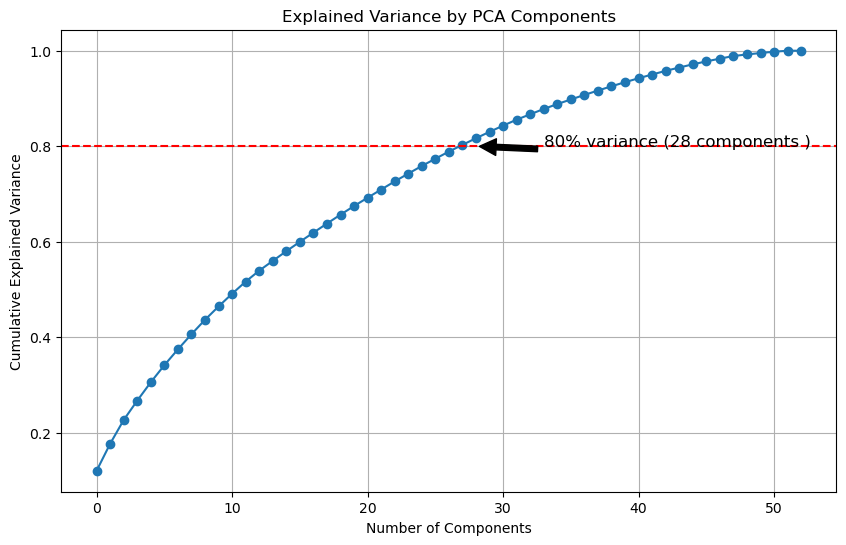

In [48]:
# Determine the number of components for 80% variance
num_components = np.where(explained_variance > 0.80)[0][0] + 1
# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)

# Add a horizontal line at the 80% variance
plt.axhline(y=0.80, color='r', linestyle='--')
# Add an annotation for the number of components
plt.annotate(f'80% variance ({num_components} components )', xy=(num_components, 0.80), xytext=(num_components+5, 0.80),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.show()

### 4.5 Decision Tree with PCA Components

In this part we construct and train the decision tree classifier using the principal components derived from PCA as inputs. 

In [49]:
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(df[numeric_features])
y = final_merged_data['accident_severity']  # set target variable accident_severity

**Single Decision Tree with confuison matrix and classification report**

In [50]:
#split 20% of data to be test data while 80% to be training data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
# Training a single Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Evaluate the performance
print("Decision Tree Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Performance:
Confusion Matrix:
 [[   0   34   12]
 [   0  789  767]
 [   0  217 8348]]
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        46
           2       0.76      0.51      0.61      1556
           3       0.91      0.97      0.94      8565

    accuracy                           0.90     10167
   macro avg       0.56      0.49      0.52     10167
weighted avg       0.89      0.90      0.89     10167



**Random Forest**

Unlike simple decision tree random forests are a combination of tree predictors such that each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest (Breiman, 2001).

**Hyperparameter Tuning**

As machine Leaning methods, have some hyper-parameters whose values directly affect the performance of the induced models (Sociedade Brasileira de Computação et al., 2016). For the tree ensemble, the parameter like max_depth, learning rate will affect the model's performance directly. Therefore, we're going to get the best parameter set first. **Please note** that we only done the hyperparameter tuning for the Random Forest and ADT model as hperparameter tuning is computationally expensive. 

**GridSearch**

One of the simplest hyper parameter tuning strategies is grid search, in which all possible combinations of given discrete parameter spaces are evaluated and continuous parameters have to be discretized beforehand (Probst et al., 2019). However gridsearch can be computationally expensive, especially with large datasets as we have about 50000 entires here. Therefore, we only utilize a smaller number of set for hyperparameter tuning.

**Uncomment the Following Code if you want to run the GrideSearch By yourself**

In [51]:
# # Define the parameter grid for Random Forest
# param_grid_forest = {
#     'n_estimators': [50, 100, 200], #the number of trees in the forest
#     'max_depth': [5, 10, 15], #the maximum depth of each tree
#     'min_samples_split': [2, 5, 10], #the minimum number of samples required to split an internal node
# }

# # Initialize the GridSearchCV object for Random Forest
# grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_forest, cv=5, scoring='accuracy')

# # Perform grid search
# grid_search_forest.fit(X_train, y_train)

# # Output the best parameters and the corresponding score
# print(f"Best parameters for Random Forest: {grid_search_forest.best_params_}")
# print(f"Best score for Random Forest: {grid_search_forest.best_score_:.2f}")

**n_estimators**: the number of trees in the forest \
**max_depth**:  the maximum depth of each tree \
**min_samples_split**: the minimum number of samples required to split an internal node 

**Best Parameter** \
The best parameters for Random Forest from GridSearch is : {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}

**Following Code are running the Random Forest Model Based on the Best Parameter From the Grid Search**

In [52]:
#evaluate on the test set using the best parameters
# best_forest = grid_search_forest.best_estimator_
# y_pred_best_forest = best_forest.predict(X_test)
# print("Best Random Forest Performance:")
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_forest))
# print("Classification Report:\n", classification_report(y_test, y_pred_best_forest))

In [53]:
#get the best parameter from the GridSearch and input it manually here
best_forest = RandomForestClassifier(max_depth=15, min_samples_split=2, n_estimators=200, random_state=42)
# Fit the best random forest model to the training data
best_forest.fit(X_train, y_train)
# Predict on the test data using the best model
y_pred_best_forest = best_forest.predict(X_test)
# Evaluate the best model's performance
print("Best Random Forest Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_forest))
print("Classification Report:\n", classification_report(y_test, y_pred_best_forest))

Best Random Forest Performance:
Confusion Matrix:
 [[  21   16    9]
 [   0 1280  276]
 [   0    0 8565]]
Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.46      0.63        46
           2       0.99      0.82      0.90      1556
           3       0.97      1.00      0.98      8565

    accuracy                           0.97     10167
   macro avg       0.99      0.76      0.84     10167
weighted avg       0.97      0.97      0.97     10167



**ADT-Boosted Decision Tree**

The AdaBoost method makes use of very tiny decision trees, each with only one level, to represent weak learners, and these learners are added progressively to the ensemble (Deeban & Bharathi, 2022).

**Get the Best Hyper-parameter set**

In [54]:
# #set the parameter set here
# param_grid_adb = {
#     'base_estimator__max_depth': [1, 2, 3],# the maximum depth of the individual estimators.
#     'n_estimators': [50, 60, 200],# the number of base estimators to be used in the ensemble
#     'learning_rate': [0.01, 0.1, 0.2], # weight applied to each classifier at each boosting iteration
# }


# # Initialize the GridSearchCV object for AdaBoost
# base_estimator = DecisionTreeClassifier(random_state=42)
# adb_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)
# grid_search_adb = GridSearchCV(adb_clf, param_grid_adb, cv=5, scoring='accuracy')

# # Perform grid search
# grid_search_adb.fit(X_train, y_train)

# # Output the best parameters and the corresponding score
# print(f"Best parameters for AdaBoost: {grid_search_adb.best_params_}")
# print(f"Best score for AdaBoost: {grid_search_adb.best_score_:.2f}")

In [55]:
# #evaluate on the test set using the best parameters
# best_adb = grid_search_adb.best_estimator_
# y_pred_best_adb = best_adb.predict(X_test)
# print("Best AdaBoost Performance:")
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_adb))
# print("Classification Report:\n", classification_report(y_test, y_pred_best_adb))

**Please note that we run the code above in the Google Colab to get the best parameter**

Best parameters for AdaBoost: {'base_estimator__max_depth': 1, 'learning_rate': 0.2, 'n_estimators': 60}
Best score for AdaBoost: 0.95

In [56]:
best_adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=60,
    learning_rate=0.2
)

# Fit the best AdaBoost model to the training data
best_adaboost.fit(X_train, y_train)

# Predict on the test data using the best model
y_pred_best_adaboost = best_adaboost.predict(X_test)

# Evaluate the best model's performance
print("Best AdaBoost with Decision Tree Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_adaboost))
print("Classification Report:\n", classification_report(y_test, y_pred_best_adaboost))

Best AdaBoost with Decision Tree Performance:
Confusion Matrix:
 [[   0   35   11]
 [   0 1139  417]
 [   0  135 8430]]
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        46
           2       0.87      0.73      0.80      1556
           3       0.95      0.98      0.97      8565

    accuracy                           0.94     10167
   macro avg       0.61      0.57      0.59     10167
weighted avg       0.93      0.94      0.94     10167



## 5.0 Results

The casualty_severity' seems to be a crucial node from the returning decision rules while the location_northing_osgr and location_easting_osgr appear in the tree indicating that specific geographic areas are more prone to accidents. Additionally, the presence of 'first_road_number' hints at particular roads being associated with different accident severities. Finally, multiple casualties in an accident (number_of_casualties > 2.50) can lead to higher severity.

The AdaBoost model have high precision for slight accidents(0.95) but it may not be able to identify the fatal accidents. Overall its accuracy is 0.94. The Random Forest model performs better in predicting fatal accidents with perfect precision but moderate recall (1.00 and 0.52 respectively), which suggests when it predicts a fatal accident, it is always correct, but it only catches about half of them. As to slight and serious accidents it has better perfromance as well. Overall, its performance(0.97) is slightly better than ADT. The normal decision tree model has 0.91 accuracy but as well as other two models

## 6.0 Discussing and Conclusion

**Limitation and Futrue Work**

Notwithstanding we do the Z-score outlier detection it seems it's not enough for finding the outliers as most of the values in the dataset is categorical coding. Nevertheless, the outliers may affect the performance of the model correspondingly. Additionally, the temporal analysis is mainly covered by the new variable weekday vs weekend created in the feature engineering but the daytime and nighttime and specific rush hours should also be taken into account. Besides, the it's ambiguious to use the classifciation of urban vs rural and we use inner and outer in analysis instead. Finally, due to the time constraint and computational resources restriction we don't explore many parameters set in the grid search part.

Therefore, in the future, we could refine these obscure classifications, incorporating more granular temporal data (such as rush hours), and explore other predictive variables that could affect the accuracy and applicability of the model. Besides, for the temporal analysis we will also focus and the daytime, nightime and different seasons which can be combined with weather conditions for more accurate analysis. Furthremore, hyperparameter optimization will be carried out thoroughly to improve performance and avoid the possible issue of overfitting.

**Conclusion**

The rules from decision trees imply that reducing the impact of accidents should be a top priority for policymakers and in specific geographic coordinates accident severity is higher. Therefore, investing in road safety infrastructure, such as better road surfaces could help in mitigating the severity of accidents. Although the urban vs. rural classification is not directly reflected in the decision tree analysis, it's  clear from the feature engineering and data visualizations that rural areas have specific safety challenges that require attention, such as improving road lighting. While data visualizations suggest a higher accident severity during weekends, which might warrant increased traffic monitoring and enforcement during these times.

Random Forest model appears to be the most robust across all classes of accidents, showing good precision and recall in most cases. However, the recall for class fatal accidents across all models is an area that could be improved, perhaps through retraining with a larger or more balanced dataset or by tweaking the model parameters to better handle minority classes. The ADT model, while slightly less accurate overall, still shows good precision for severe accidents. The basic Decision Tree model appears to be the weakest, particularly in identifying serious and fatal accidents perhaps due to the lack of hyperparameter optimization.

## References

Abellán, J., López, G., & De Oña, J. (2013). Analysis of traffic accident severity using Decision Rules via Decision Trees. Expert Systems with Applications, 40(15), 6047–6054. https://doi.org/10.1016/j.eswa.2013.05.027 \
Alin, A. (2010). Multicollinearity. Wiley Interdisciplinary Reviews: Computational Statistics, 2(3), 370–374. https://doi.org/10.1002/wics.84 \
Bhavan, T. (2019). The Economic Impact of Road Accidents: The Case of Sri Lanka. South Asia Economic Journal, 20(1), 124–137. https://doi.org/10.1177/1391561418822210 \
Breiman, L. (2001). Random Forests (Vol. 45). \
Deeban, N., & Bharathi, P. S. (2022). BDT: An Ada Boost Classifier Ensemble with Decision Tree for Traffic Network Prediction. Proceedings of 5th International Conference on Contemporary Computing and Informatics, IC3I 2022, 1926–1931. https://doi.org/10.1109/IC3I56241.2022.10072623 \
Elvik, R. (2008). Dimensions of road safety problems and their measurement. Accident Analysis and Prevention, 40(3), 1200–1210. https://doi.org/10.1016/j.aap.2008.01.004 \
Elyassami, S., Hamid, Y., & Habuza, T. (2020). Road crashes analysis and prediction using gradient boosted and random forest trees. Colloquium in Information Science and Technology, CIST, 2020-June, 520–525. https://doi.org/10.1109/CiSt49399.2021.9357298 \
Hauer, E. (2010). On prediction in road safety. Safety Science, 48(9), 1111–1122. https://doi.org/10.1016/j.ssci.2010.03.003 \
Hughes, B. P., Newstead, S., Anund, A., Shu, C. C., & Falkmer, T. (2015). A review of models relevant to road safety. Accident Analysis and Prevention, 74, 250–270. https://doi.org/10.1016/j.aap.2014.06.003 \
Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. 32nd International Conference on Machine Learning, ICML 2015, 1, 448–456. \
Josse, J., & Husson, F. (2012). Selecting the number of components in principal component analysis using cross-validation approximations. Computational Statistics and Data Analysis, 56(6), 1869–1879. https://doi.org/10.1016/j.csda.2011.11.012 \
Nargesian, F., Samulowitz, H., Khurana, U., Khalil, E. B., & Turaga, D. (2017). Learning feature engineering for classification. IJCAI International Joint Conference on Artificial Intelligence, 0, 2529–2535. https://doi.org/10.24963/ijcai.2017/352 \
Pateman, T. (2010). Rural and urban areas: comparing lives using rural/urban classifications. www.statistics.gov.uk/downloads/theme_compendia/RegionalSnapshot/rt43-rural-urban-areas.xls \
Probst, P., Wright, M. N., & Boulesteix, A. L. (2019). Hyperparameters and tuning strategies for random forest. In Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery (Vol. 9, Issue 3). Wiley-Blackwell. https://doi.org/10.1002/widm.1301 \
Sociedade Brasileira de Computação, IEEE Computer Society, & Institute of Electrical and Electronics Engineers. (2016). 2016 5th Brazilian Conference on Intelligent Systems : BRACIS 2016 : proceedings : Recife, Pernambuco, Brazil, 9-12 October 2016. \
Wijnen, W., & Stipdonk, H. (2016). Social costs of road crashes: An international analysis. Accident Analysis and Prevention, 94, 97–106. https://doi.org/10.1016/j.aap.2016.05.005
